In [665]:
# Standard libraries Imports
import json
# Third party Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Local imports
from src.utils import count_plot_percentage
from src.utils import one_hot_encoding




In [483]:
data = pd.read_csv("data/Citywide_Mobility_Survey_-_Person_Survey_2019.csv")

In [484]:
data.head()

,hh_id,weight,cms_zone,survey_mode,person_id,person_num,is_participant,num_days,num_days_complete,num_trips,...,race_native_hawaiian,race_white,race_other,disability_hearing,disability_seeing,disability_walking,disability_mobility,disability_dressing,disability_concentrating,disability_none
0,191546322,0.00000,Inner Brooklyn,1,19154632203,3,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
1,191546322,0.00000,Inner Brooklyn,1,19154632202,2,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
2,191546322,212.12729,Inner Brooklyn,1,19154632201,1,1,7.0,7.0,23.0,...,1,0,0,0,0,0,0,0,0,1
3,19241657,0.00000,Middle Queens,1,1924165703,3,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995
4,19241657,0.00000,Middle Queens,1,1924165702,2,0,NaN,NaN,NaN,...,995,995,995,995,995,995,995,995,995,995


* Observe having nominal data(categoricals represented by numbers). s.t. is_participant, race, and disability columns
* Observe having NULL values

In [485]:
data.describe()

,hh_id,weight,survey_mode,person_id,person_num,is_participant,num_days,num_days_complete,num_trips,num_walk_trips,...,race_native_hawaiian,race_white,race_other,disability_hearing,disability_seeing,disability_walking,disability_mobility,disability_dressing,disability_concentrating,disability_none
count,8.286000e+03,8286.000000,8286.000000,8.286000e+03,8286.000000,8286.000000,3346.000000,3346.000000,3346.000000,3346.000000,...,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000,8286.000000
mean,2.468398e+07,804.993000,1.246681,2.468398e+09,2.146633,0.403814,5.475792,4.334130,25.540646,10.004782,...,638.420468,638.613444,638.453295,617.448467,617.443036,617.467053,617.445571,617.442674,617.449071,617.774922
std,2.974500e+07,4395.258128,0.496917,2.974500e+09,1.317302,0.490691,2.612294,2.524525,21.900434,12.091553,...,477.339270,477.081235,477.295392,482.943289,482.950227,482.919543,482.946990,482.950690,482.942518,482.525910
min,1.900024e+07,0.000000,1.000000,1.900024e+09,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.926343e+07,0.000000,1.000000,1.926343e+09,1.000000,0.000000,1.000000,1.000000,4.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.951784e+07,0.000000,1.000000,1.951784e+09,2.000000,0.000000,7.000000,5.000000,24.000000,5.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
75%,1.979496e+07,199.885270,1.000000,1.979496e+09,3.000000,1.000000,7.000000,7.000000,41.000000,16.000000,...,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000,995.000000
max,1.999892e+08,88819.119060,3.000000,1.999892e+10,11.000000,1.000000,7.000000,7.000000,178.000000,93.000000,...,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000


Though most of the features are nominal, but observe for quantitative data(jobs_count for example) that missing values, e.g., -9998 and 995, are affecting the results

In [486]:
# information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8286 entries, 0 to 8285
Columns: 165 entries, hh_id to disability_none
dtypes: float64(20), int64(140), object(5)
memory usage: 10.4+ MB


* Observe most of the values for 'work_park_amount_day', 'work_park_amount_week', 'work_park_amount_month' features are NULL
* and 'work_cms_zone' have more than 60% NULLs
* Observe 3 data types, will detect if we have more than these 3

In [487]:
data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

* Observe having 'O' datatype, let's detect it

In [488]:
data.select_dtypes(include=['O']).columns

Index(['cms_zone', 'first_travel_date', 'last_travel_date', 'work_cms_zone',
       'school_cms_zone'],
      dtype='object')

In [489]:
data.select_dtypes(['O'])

,cms_zone,first_travel_date,last_travel_date,work_cms_zone,school_cms_zone
0,Inner Brooklyn,06/24/2019,06/30/2019,NaN,NaN
1,Inner Brooklyn,06/24/2019,06/30/2019,NaN,NaN
2,Inner Brooklyn,06/24/2019,06/30/2019,NaN,NaN
3,Middle Queens,05/29/2019,06/04/2019,NaN,NaN
4,Middle Queens,05/29/2019,06/04/2019,NaN,NaN
...,...,...,...,...,...
8281,Staten Island,06/15/2019,06/15/2019,NaN,NaN
8282,Staten Island,06/03/2019,06/03/2019,Staten Island,NaN
8283,Staten Island,06/03/2019,06/03/2019,NaN,NaN
8284,Staten Island,06/03/2019,06/03/2019,NaN,NaN


In [490]:
data['cms_zone'].value_counts()

Northern Bronx        1032
Staten Island         1024
Outer Queens           975
Southern Bronx         902
Middle Queens          835
Outer Brooklyn         822
Inner Brooklyn         767
Inner Queens           730
Northern Manhattan     657
Manhattan Core         542
Name: cms_zone, dtype: int64

In [491]:
print(data['work_cms_zone'].value_counts().sum())
data['work_cms_zone'].value_counts()

1687


Manhattan Core     815
Inner Brooklyn     166
Southern Bronx     122
Upper Manhattan    114
Outer Brooklyn      96
Inner Queens        79
Middle Queens       75
Staten Island       73
Northern Bronx      70
Outer Queens        69
JFK                  7
LGA                  1
Name: work_cms_zone, dtype: int64

In [492]:
set(data['cms_zone']) - set(data['work_cms_zone'])

{'Northern Manhattan'}

In [493]:
set(data['work_cms_zone']) - set(data['cms_zone'])

{'JFK', 'LGA', 'Upper Manhattan', nan}

'work_cms_zone' include more places than 'cms_zone'. e.g., 'JFK', 'LGA' airports

### Employment
* Detect employment status for majority of people
* Detect employment status relationship with transportation method used

In [494]:
data["employment"].value_counts()

1      3293
6      2185
995    1473
2       762
3       434
7       139
Name: employment, dtype: int64

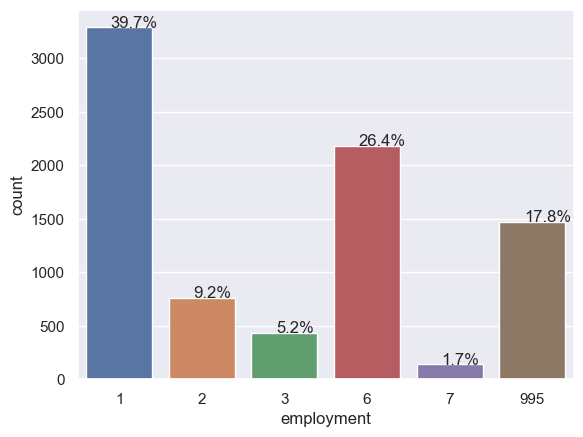

In [495]:
count_plot_percentage(data, 'employment')

* Most of the people are full-time paid employees
* Quarter of people aren't currently employed (e.g., retired, looking for work)
* Very few of people are volunteers or interns

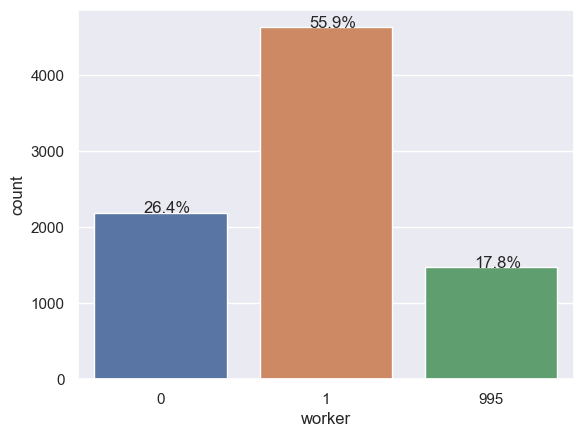

In [496]:
count_plot_percentage(data, 'worker')

* 55.9% of people are employed. Almost the half
* almost quarter of people aren't employed

In [497]:
data['jobs_count'].value_counts()

 995     5924
 1       2031
 2        231
 3         57
 6         17
-9998      15
 4          8
 5          3
Name: jobs_count, dtype: int64

In [498]:
data['job_type'].value_counts()

 995     5924
 1       1627
 2        497
 3        135
 4         88
-9998      15
Name: job_type, dtype: int64

Most usual work location for people is **one** work location, regardless of being a telework or onsite

In [499]:
data['industry'].value_counts().sort_values(ascending=False)

 995     5924
 8        337
 7        298
 18       247
 4        221
 1        211
 14       167
 16       129
 10       128
 15       124
 9        100
 12        91
 5         87
 17        60
 2         60
 13        43
 11        28
-9998      15
 6         13
 3          3
Name: industry, dtype: int64

* Most of them Missing: Skip logic
* Only 3 of them their work industry is: Capital goods (aerospace & defense, electrical, machinery)
* Most work industry in which people work in is: Health care/social assistance

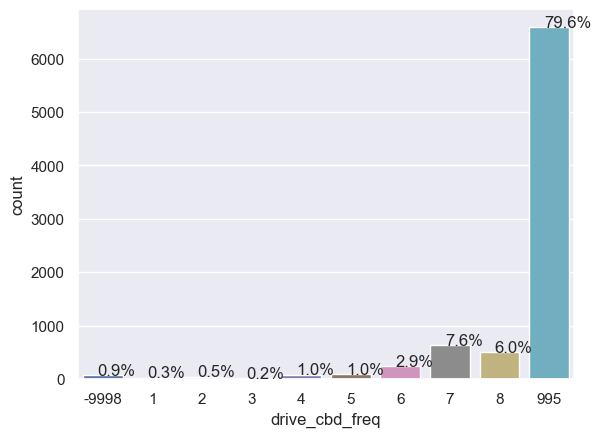

In [500]:
count_plot_percentage(data, 'drive_cbd_freq')

Regardless of 995(Missing: Skip logic), The majority of people who filled out the survey are those with least Frequency of driving vehicle into or within the area of Manhattan south of 60th Street

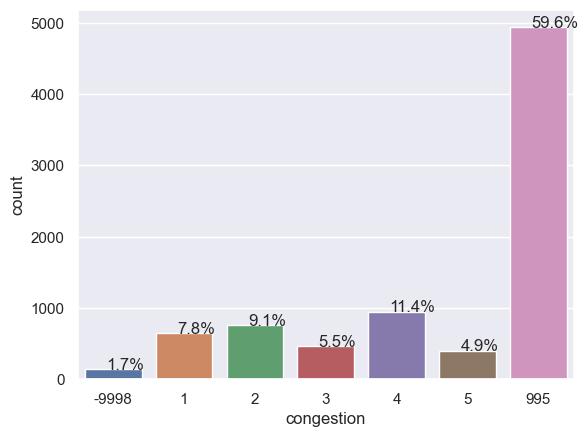

In [501]:
count_plot_percentage(data, 'congestion')

Proportion of people opposing and supporting the congistion almost equal

<AxesSubplot: xlabel='congestion', ylabel='count'>

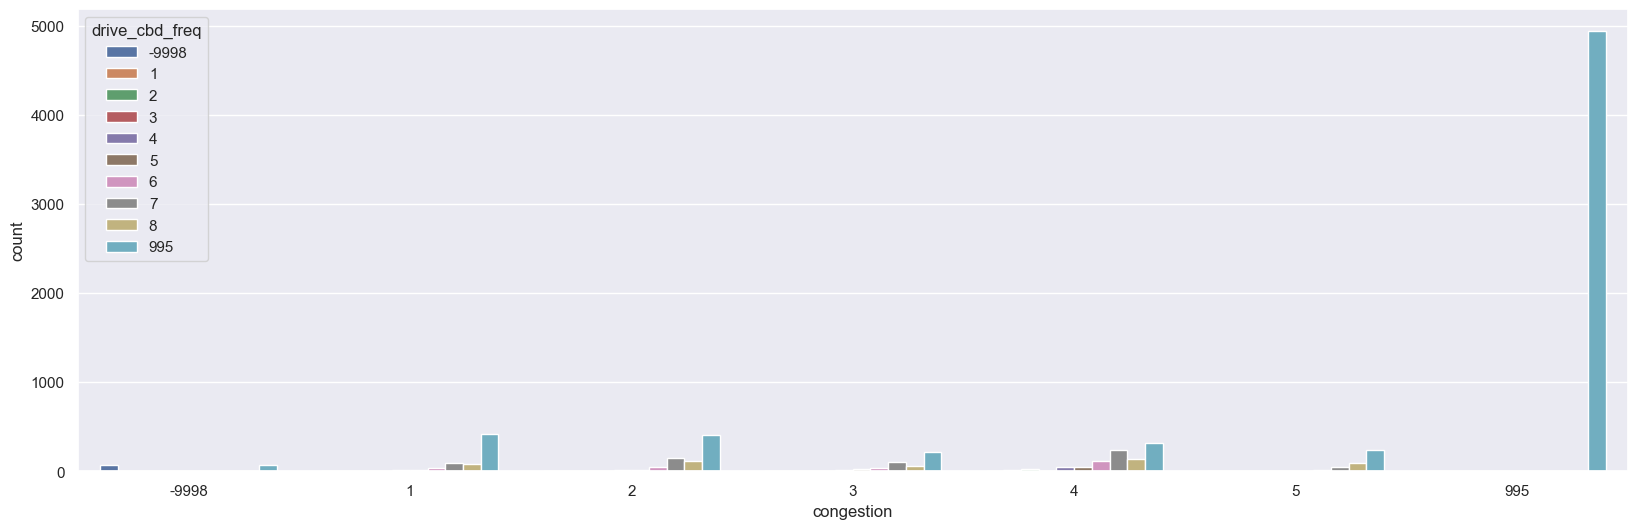

In [502]:
# Observe wheter people's frequency of driving vehicle into or within the area of Manhattan south of 60th Street affects supporting/opposing congesiton
plt.figure(figsize=(20, 6))
sns.countplot(x='congestion', hue='drive_cbd_freq', data=data)

No clear inferences, sounds that people who have never drived into or within Manhattan have alost equal voting with regard to congestion

In [503]:
data.groupby("congestion")["drive_cbd_freq"].value_counts()

congestion  drive_cbd_freq
-9998       -9998               73
             995                65
 1           995               413
             7                  87
             8                  86
             6                  30
             4                   8
             5                   8
             2                   7
             1                   3
             3                   3
 2           995               405
             7                 150
             8                 118
             6                  50
             5                  11
             4                  10
             2                   7
             1                   4
             3                   1
 3           995               218
             7                 107
             8                  61
             6                  37
             5                  19
             4                   9
             1                   3
             2              

Expect that people with more telework frequency support congestion and vice versa, let's detect that

<AxesSubplot: xlabel='telework_freq', ylabel='count'>

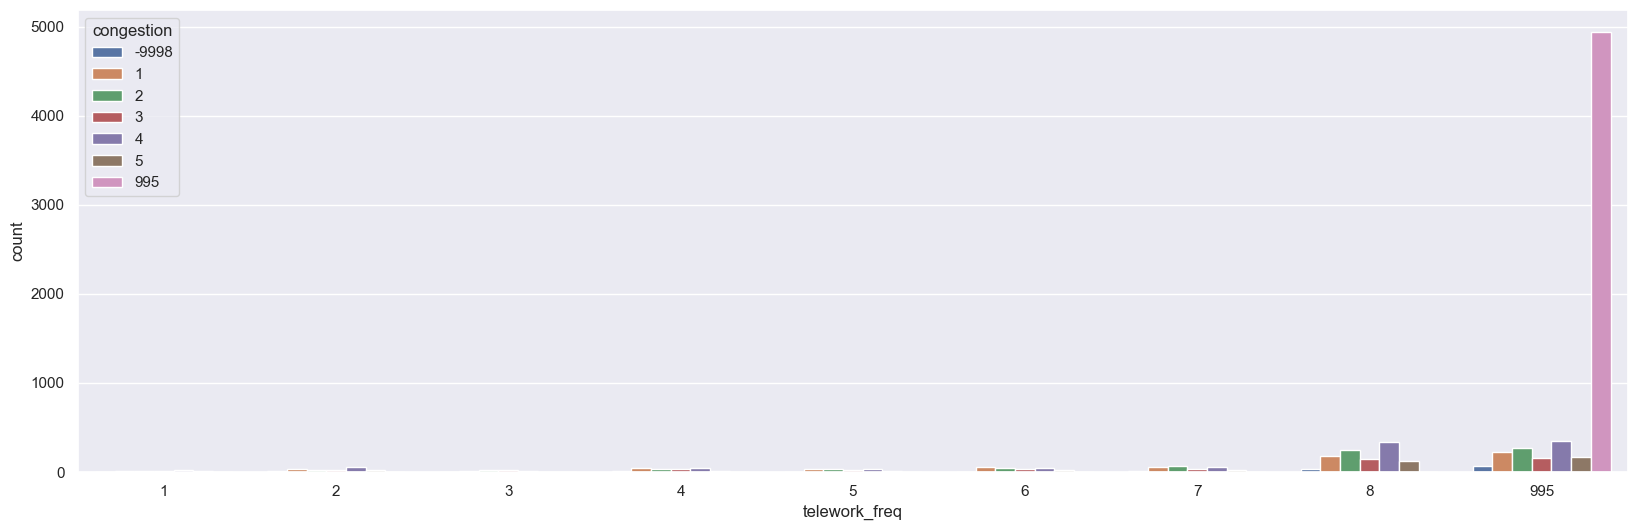

In [504]:
plt.figure(figsize=(20, 6))
sns.countplot(x='telework_freq', hue='congestion', data=data)

besides missing(skip logic), the majority voting is from people with no telework. Appear that most of them highly opposing congestion

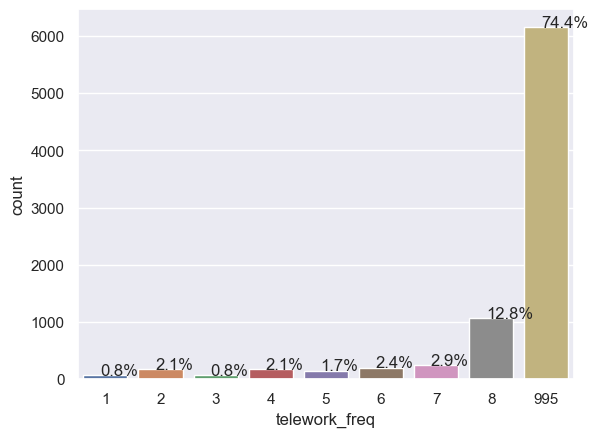

In [505]:
count_plot_percentage(data, 'telework_freq')

As detected from previous plot, majority of them are those with no telework, and missing(skip logic)

In [506]:
data['bike_num_days'].value_counts()

995    7007
0      1090
1        68
2        37
3        30
4        17
5        15
6        12
7        10
Name: bike_num_days, dtype: int64

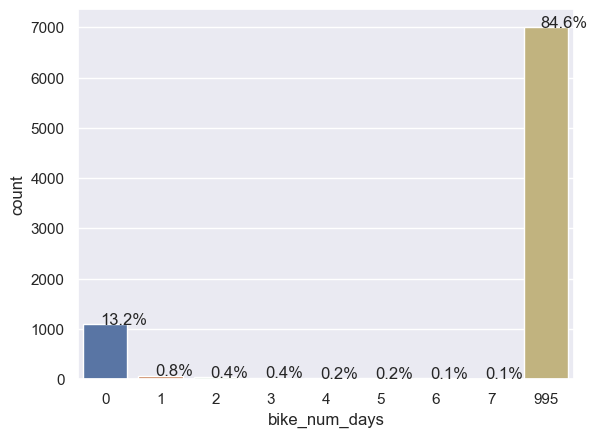

In [507]:
count_plot_percentage(data, 'bike_num_days')

Most of people don't ride a bike The whole week

<AxesSubplot: xlabel='bike_num_days', ylabel='count'>

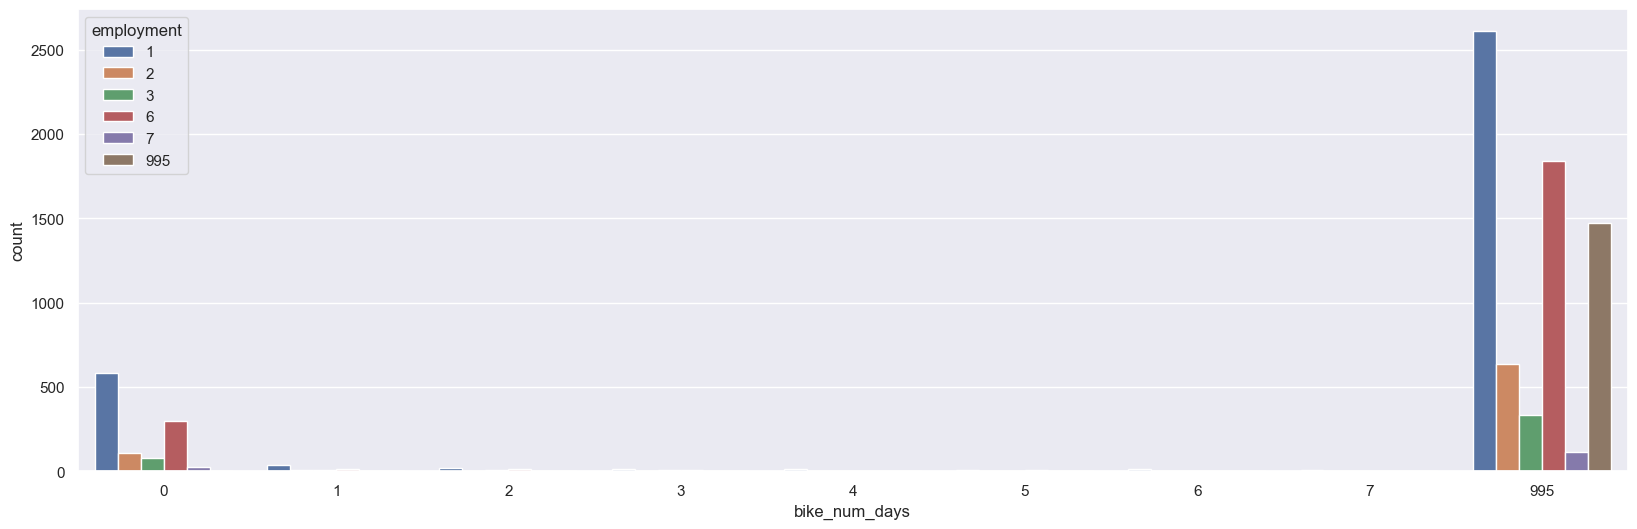

In [508]:
# Detect Bike && unemployed
plt.figure(figsize=(20, 6))
sns.countplot(x='bike_num_days', hue='employment', data=data)

In [509]:
trip_data = data[['hh_id','weight','cms_zone','survey_mode','person_id','person_num','is_participant','num_days','num_days_complete','num_trips','num_walk_trips','num_transit_trips','num_bike_trips','num_taxi_trips','num_tnc_trips','num_complete_weekend_days','num_complete_weekdays','first_travel_date','last_travel_date','made_trips','smartphone_type',
             'relationship','age','employment','worker']]

In [510]:
# Check unique values for each feature
obj = trip_data.nunique()
for key,value in obj.iteritems():
    print(key,",",value)

hh_id , 3346
weight , 2497
cms_zone , 10
survey_mode , 3
person_id , 8286
person_num , 11
is_participant , 2
num_days , 2
num_days_complete , 7
num_trips , 109
num_walk_trips , 68
num_transit_trips , 45
num_bike_trips , 25
num_taxi_trips , 11
num_tnc_trips , 14
num_complete_weekend_days , 3
num_complete_weekdays , 6
first_travel_date , 39
last_travel_date , 40
made_trips , 2
smartphone_type , 5
relationship , 10
age , 11
employment , 6
worker , 3


C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\168939690.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key,value in obj.iteritems():


In [511]:
trip_data.dtypes

hh_id                          int64
weight                       float64
cms_zone                      object
survey_mode                    int64
person_id                      int64
person_num                     int64
is_participant                 int64
num_days                     float64
num_days_complete            float64
num_trips                    float64
num_walk_trips               float64
num_transit_trips            float64
num_bike_trips               float64
num_taxi_trips               float64
num_tnc_trips                float64
num_complete_weekend_days    float64
num_complete_weekdays        float64
first_travel_date             object
last_travel_date              object
made_trips                   float64
smartphone_type                int64
relationship                   int64
age                            int64
employment                     int64
worker                         int64
dtype: object

##### hh_id & person_id will be removed, it provides no extra information about the data
##### first_travel_date and last_travel_date will be removed in this iteration, not clearly understandable yet
##### num_days and num_days_complete won't be included in this iteration, need more information about them

In [512]:
data.drop(['hh_id','person_id','weight','first_travel_date','last_travel_date','num_days','num_days_complete'],axis=1, inplace=True)

##### only data when is_participant equals to 1 will be selected then drop the column, current information: not participant doesn't help in survey information, almost all data is null when is_participant equals to 0 

In [513]:
data_when_is_participant_zero = data[data['is_participant'] == 0]

In [514]:
# check sum of nulls 
obj = data_when_is_participant_zero.isnull().sum()
obj.sort_values(ascending=False)

num_complete_weekend_days     4940
num_taxi_trips                4940
work_park_amount_week         4940
work_park_amount_day          4940
made_trips                    4940
                              ... 
school_vehicle_pass_period       0
school_park_location             0
school_mode_own                  0
school_mode                      0
disability_none                  0
Length: 158, dtype: int64

In [515]:
# data = data[data['is_participant'] == 1]

In [516]:
obj = data.nunique()
for key,value in obj.iteritems():
    print(key,",",value)

cms_zone , 10
survey_mode , 3
person_num , 11
is_participant , 2
num_trips , 109
num_walk_trips , 68
num_transit_trips , 45
num_bike_trips , 25
num_taxi_trips , 11
num_tnc_trips , 14
num_complete_weekend_days , 3
num_complete_weekdays , 6
made_trips , 2
smartphone_type , 5
relationship , 10
age , 11
employment , 6
worker , 3
student , 3
license , 4
vehicle , 10
congestion , 7
drive_cbd_freq , 10
planning_apps , 10
job_type , 6
jobs_count , 8
industry , 20
telework_freq , 9
work_cms_zone , 12
missing_work_location , 2
work_mode , 10
work_mode_own , 5
work_park_location , 6
work_park_pay , 7
work_vehicle_pass_period , 6
work_park_amount_day , 11
work_park_amount_week , 10
work_park_amount_month , 16
work_park_amount_year , 4
work_mode_auto , 6
work_mode_bus , 8
work_mode_rail , 6
work_mode_ferry , 3
work_mode_taxi , 6
work_mode_bike , 5
work_bike_park , 8
work_mode_scooter , 1
work_scooter_park , 1
school_type , 14
school_cms_zone , 10
missing_school_location , 2
kid_accompany , 3
school

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\3930099614.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key,value in obj.iteritems():


##### as a result person_num and relationship feature will be deleted because they have on value

In [517]:
data.drop(['person_num','relationship'],axis=1,inplace=True)

In [518]:
trips_numerical_data = data[['num_trips','num_walk_trips','num_transit_trips','num_bike_trips','num_taxi_trips','num_tnc_trips','num_complete_weekend_days',
                      'num_complete_weekdays']]

In [519]:
trips_numerical_data.describe()

,num_trips,num_walk_trips,num_transit_trips,num_bike_trips,num_taxi_trips,num_tnc_trips,num_complete_weekend_days,num_complete_weekdays
count,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000,3346.000000
mean,25.540646,10.004782,5.827555,0.419307,0.111775,0.374776,1.266886,3.067244
std,21.900434,12.091553,7.646751,2.141812,1.664201,1.181070,0.843984,1.858192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,24.000000,5.000000,2.000000,0.000000,0.000000,0.000000,2.000000,4.000000
75%,41.000000,16.000000,10.000000,0.000000,0.000000,0.000000,2.000000,5.000000
max,178.000000,93.000000,57.000000,36.000000,92.000000,18.000000,2.000000,5.000000


##### from the frequency matrix -columns features, rows values- 
##### for example count of 1 of survey_mode is the most frequent which means people filled the survey by using rMove (smartphone app)
##### Northern Bronx is the most frequent cms_zone
##### Age values are between 5 and 11, which means 18yo and older
##### most answers from people has iphone mobile 

In [520]:
# display correlation matrix between features
numeric_corr_matrix = trips_numerical_data.corr()
numeric_corr_matrix

,num_trips,num_walk_trips,num_transit_trips,num_bike_trips,num_taxi_trips,num_tnc_trips,num_complete_weekend_days,num_complete_weekdays
num_trips,1.000000,0.685732,0.574478,0.162543,0.081621,0.187826,0.494895,0.530072
num_walk_trips,0.685732,1.000000,0.610044,0.116651,0.021248,0.183317,0.428865,0.468685
num_transit_trips,0.574478,0.610044,1.000000,0.009034,0.015657,0.135196,0.346632,0.380096
num_bike_trips,0.162543,0.116651,0.009034,1.000000,0.007480,0.062776,0.090722,0.105136
num_taxi_trips,0.081621,0.021248,0.015657,0.007480,1.000000,0.033284,0.036010,0.036915
num_tnc_trips,0.187826,0.183317,0.135196,0.062776,0.033284,1.000000,0.155752,0.166960
num_complete_weekend_days,0.494895,0.428865,0.346632,0.090722,0.036010,0.155752,1.000000,0.703968
num_complete_weekdays,0.530072,0.468685,0.380096,0.105136,0.036915,0.166960,0.703968,1.000000


##### NaN = no correlation between, they don't affect/change each other, propably going to be deleted --person_num--
##### regardless the change of person_num, num of trips kinds don't change

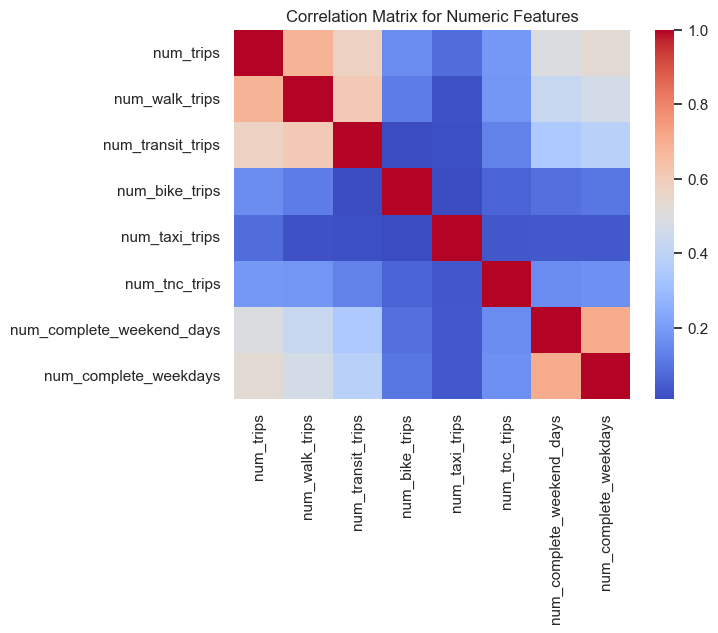

In [521]:
# Plot a correlation matrix for numeric features
sns.heatmap(numeric_corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()

In [522]:
categorical_data = data[['made_trips','smartphone_type','age','cms_zone','survey_mode']]

In [523]:
categorical_data['age'].unique()

array([ 9,  8,  5,  7,  6,  4,  3,  1,  2, 10, 11], dtype=int64)

In [524]:
# dropping age 1 (under 5) // data may be innaccurate
# data.drop(data[data['age'] == 1].index, inplace=True)

##### See Frequency/Count for each value of the categorical features

In [525]:
categorical_frequency = categorical_data.apply(pd.Series.value_counts)
categorical_frequency

,made_trips,smartphone_type,age,cms_zone,survey_mode
0.0,309.0,377.0,NaN,NaN,NaN
1.0,3037.0,1206.0,405.0,NaN,6495.0
2.0,NaN,1747.0,871.0,NaN,1538.0
3.0,NaN,16.0,197.0,NaN,253.0
4.0,NaN,NaN,795.0,NaN,NaN
5.0,NaN,NaN,1502.0,NaN,NaN
6.0,NaN,NaN,1225.0,NaN,NaN
7.0,NaN,NaN,1186.0,NaN,NaN
8.0,NaN,NaN,1067.0,NaN,NaN
9.0,NaN,NaN,696.0,NaN,NaN


<AxesSubplot: >

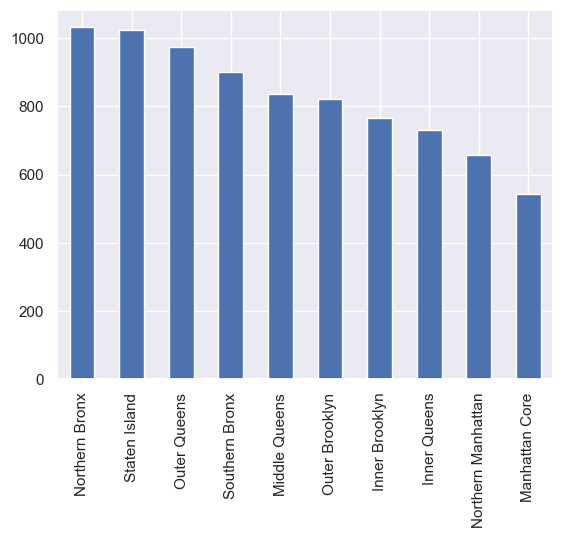

In [526]:
categorical_data['cms_zone'].value_counts().plot(kind='bar')

In [527]:
school_numerical_data = data[['school_park_amount_day','school_park_amount_week','school_park_amount_month','school_park_amount_year']]

In [528]:
school_categorical_data = data[['student','license','vehicle','congestion','school_type','school_cms_zone',
                                       'missing_school_location','kid_accompany','school_mode','school_mode_own','school_park_location',
                                       'school_vehicle_pass_period', 'school_mode_auto', 'school_mode_bus','school_mode_rail', 'school_mode_ferry', 'school_access',
                                       'school_egress', 'school_mode_taxi', 'school_mode_bike','school_bike_park', 'school_mode_scooter', 'school_scooter_park']]

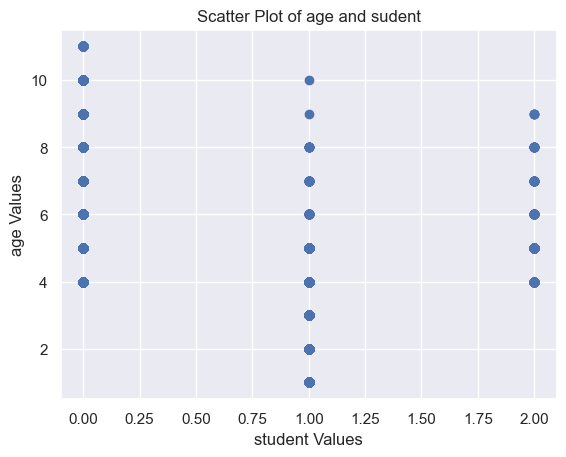

In [529]:
# Plot a scatter plot of two features
plt.scatter(data['student'], data['age'])
plt.title('Scatter Plot of age and sudent')
plt.xlabel('student Values')
plt.ylabel('age Values')
plt.show()

In [530]:
data[data['student'] == 1]['age'].unique()

array([ 5,  3,  1,  2,  4,  6,  7,  8,  9, 10], dtype=int64)

In [531]:
data.loc[data['student'] == 1]['age'].unique()

array([ 5,  3,  1,  2,  4,  6,  7,  8,  9, 10], dtype=int64)

#### from the plot
##### not students age varies between 4(18-24) and 11(85 or older)
##### full time student age varies between 1(Under 5) //dropped and 10(75-84)
##### half-time student age varies between 4(18-24) and 9(65-74)

<AxesSubplot: >

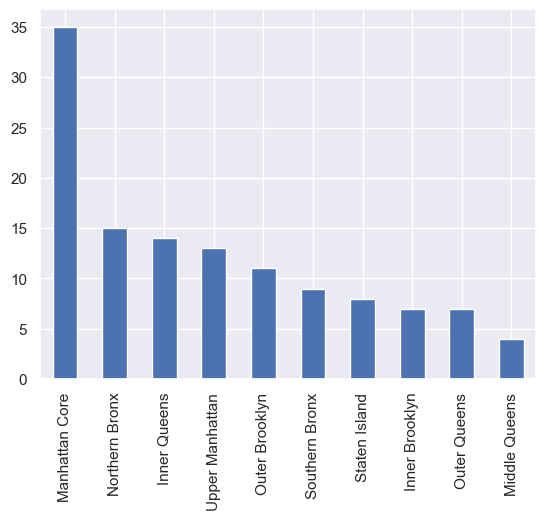

In [532]:
school_categorical_data['school_cms_zone'].value_counts().plot(kind='bar')

##### Manhattan Core has the highest number of school

<AxesSubplot: >

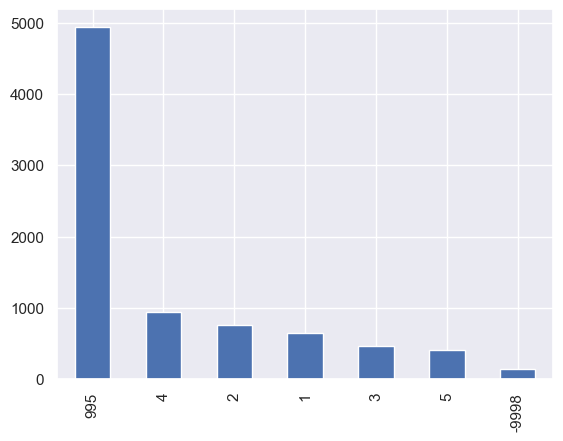

In [533]:
school_categorical_data['congestion'].value_counts().plot(kind='bar')

##### high number of people don't agree with the policy of congestion pricing (4)

In [534]:
school_numerical_data.describe()

,school_park_amount_day,school_park_amount_week,school_park_amount_month,school_park_amount_year
count,7.000000,5.000000,8.000000,8.000000
mean,7.892857,21.050000,23.781250,128.156250
std,6.177677,28.202615,21.036294,161.335882
min,0.250000,0.250000,0.250000,0.250000
25%,3.000000,4.000000,12.250000,12.250000
50%,8.000000,15.000000,18.000000,53.000000
75%,12.500000,16.000000,31.250000,212.500000
max,16.000000,70.000000,60.000000,450.000000


In [535]:
# display correlation matrix between features
numeric_corr_matrix = school_numerical_data.corr()
numeric_corr_matrix

,school_park_amount_day,school_park_amount_week,school_park_amount_month,school_park_amount_year
school_park_amount_day,1.0,1.0,1.0,1.0
school_park_amount_week,1.0,1.0,1.0,1.0
school_park_amount_month,1.0,1.0,1.0,1.0
school_park_amount_year,1.0,1.0,1.0,1.0


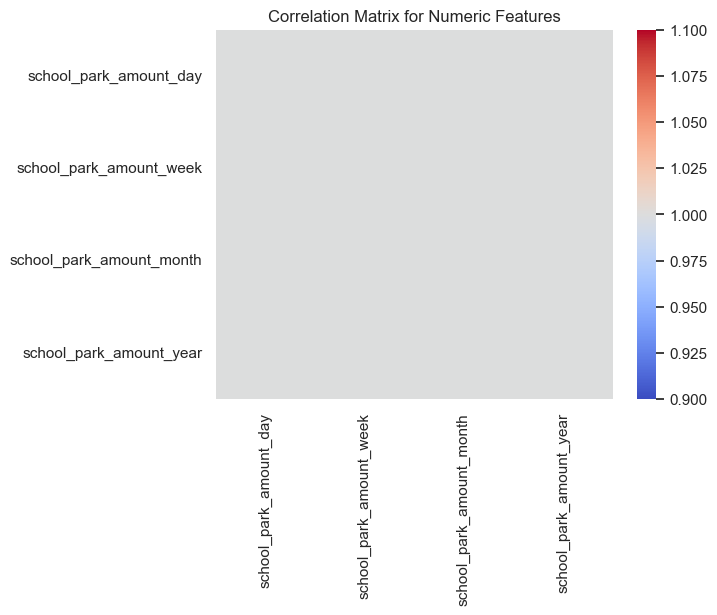

In [536]:
# Plot a correlation matrix for numeric features
sns.heatmap(numeric_corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features')
plt.show()

##### Strong Correlated

In [537]:
harassment_data = data[['harassment','harassment_private_car', 'harassment_alone', 'harassment_attention',
       'harassment_defense', 'harassment_other', 'harassment_none', 'gender',
       'education', 'english_proficiency', 'ethnicity', 'race_american_indian',
       'race_asian', 'race_black', 'race_native_hawaiian', 'race_white',
       'race_other', 'disability_hearing', 'disability_seeing',
       'disability_walking', 'disability_mobility', 'disability_dressing',
       'disability_concentrating', 'disability_none']]

<AxesSubplot: >

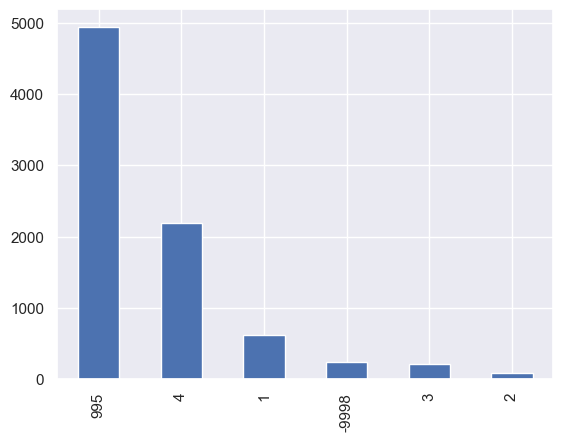

In [538]:
harassment_data['harassment'].value_counts().plot(kind='bar')

##### most haven't seen or experienced harassment (4)

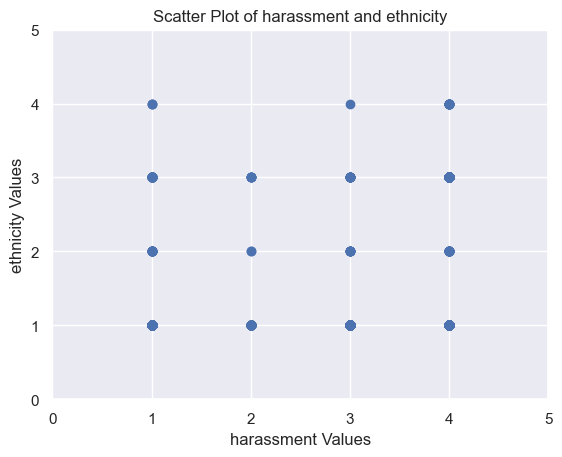

In [539]:
# Plot a scatter plot of two features
plt.scatter(harassment_data['harassment'], harassment_data['ethnicity'])
plt.title('Scatter Plot of harassment and ethnicity')
plt.xlabel('harassment Values')
plt.ylabel('ethnicity Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### all have seen and/or experienced harassment, and mexican people seem to experience it the most

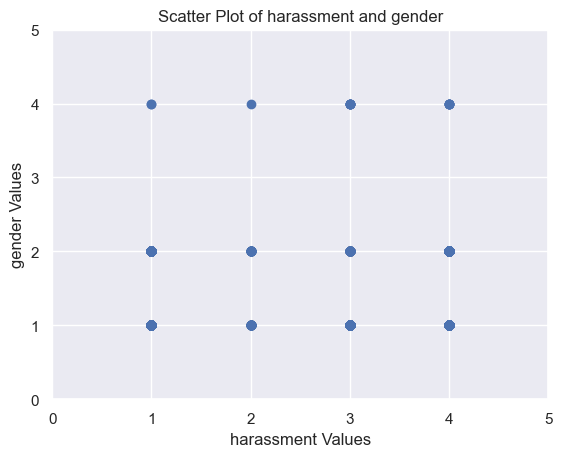

In [540]:
plt.scatter(harassment_data['harassment'], harassment_data['gender'])
plt.title('Scatter Plot of harassment and gender')
plt.xlabel('harassment Values')
plt.ylabel('gender Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### all genders are equal

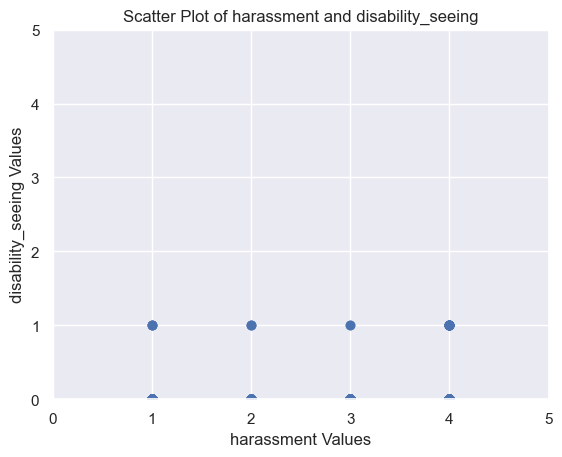

In [541]:
plt.scatter(harassment_data['harassment'], harassment_data['disability_seeing'])
plt.title('Scatter Plot of harassment and disability_seeing')
plt.xlabel('harassment Values')
plt.ylabel('disability_seeing Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### disabilities doesn't really affect

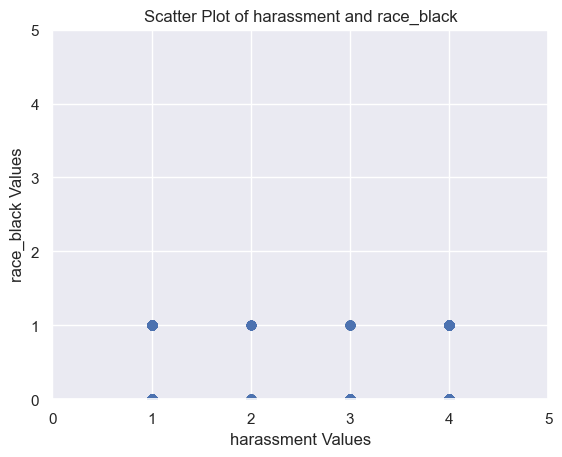

In [542]:
plt.scatter(harassment_data['harassment'], harassment_data['race_black'])
plt.title('Scatter Plot of harassment and race_black')
plt.xlabel('harassment Values')
plt.ylabel('race_black Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### black or other doesn't affect

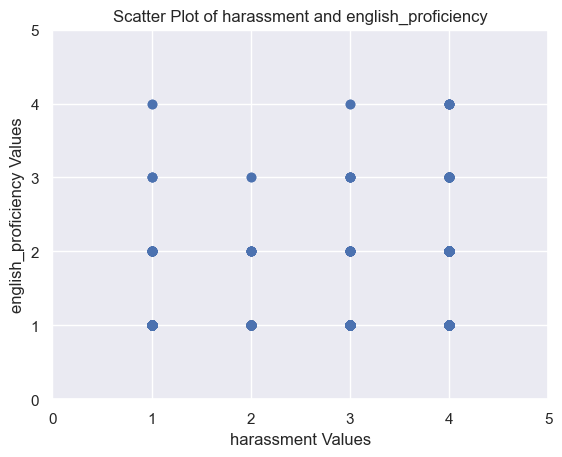

In [543]:
plt.scatter(harassment_data['harassment'], harassment_data['english_proficiency'])
plt.title('Scatter Plot of harassment and english_proficiency')
plt.xlabel('harassment Values')
plt.ylabel('english_proficiency Values')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()

##### who speaks english well got harassment

In [544]:
package_data = data[['packages','packages_distance']]

In [545]:
package_frequency = package_data.apply(pd.Series.value_counts)
package_frequency

,packages,packages_distance
-9998,234,NaN
1,696,44.0
2,1283,98.0
3,312,161.0
4,163,93.0
5,152,29.0
6,150,40.0
7,163,NaN
8,193,NaN
995,4940,7821.0


<AxesSubplot: >

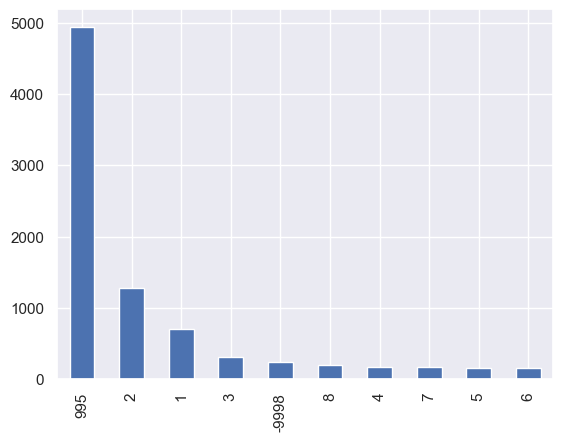

In [546]:
package_data['packages'].value_counts().plot(kind='bar')

#### most people recieve their packages at their doorsteps

<AxesSubplot: >

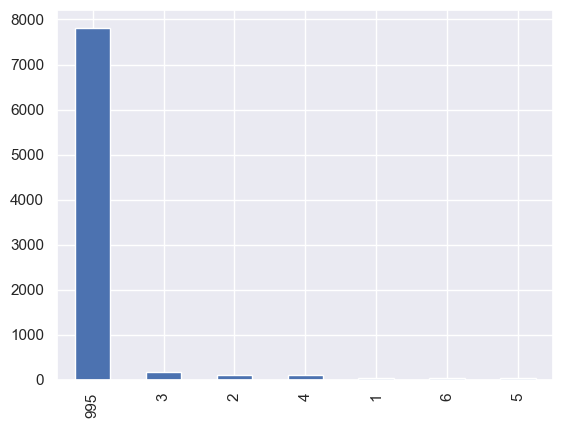

In [547]:
package_data['packages_distance'].value_counts().plot(kind='bar')

#### most people move 3 blocks away ((around neighbourhood)) to get their packages 
###### 1 block = 15 meters

In [548]:
numerical_data= pd.concat([trips_numerical_data,school_numerical_data],axis=1)

In [549]:
numerical_data['school_park_amount_year'].unique()

array([    nan, 9.0e+01, 4.5e+02, 2.5e+02, 2.0e+02, 2.5e-01, 4.0e+00,
       1.6e+01, 1.5e+01])

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


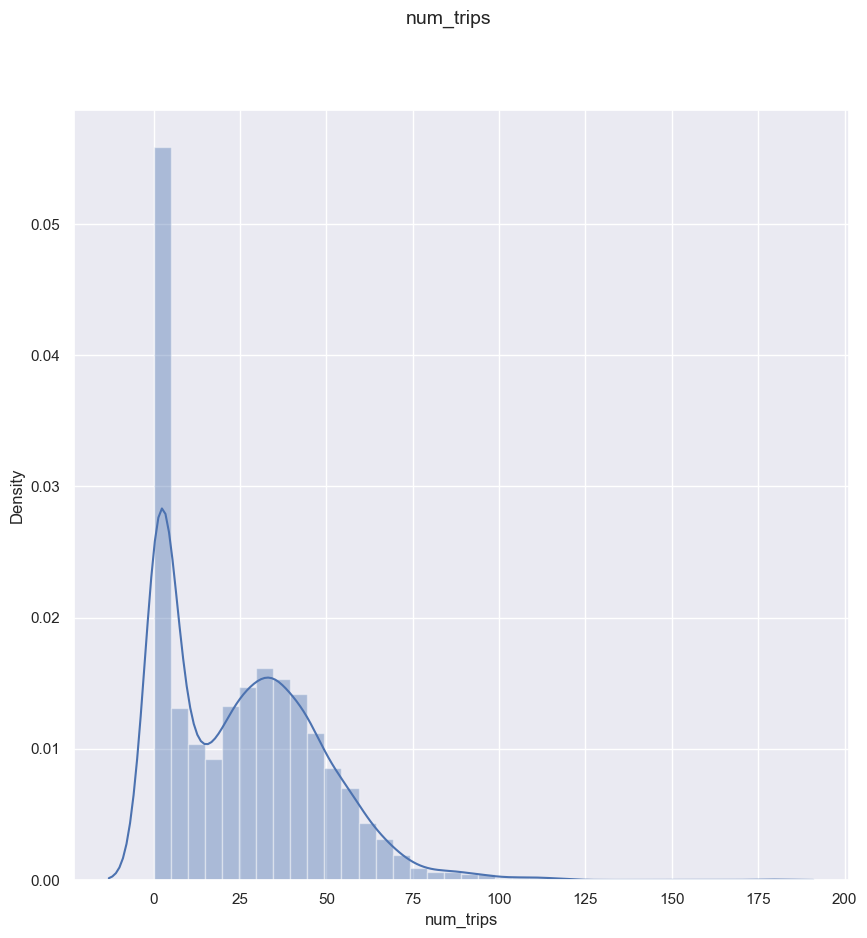

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


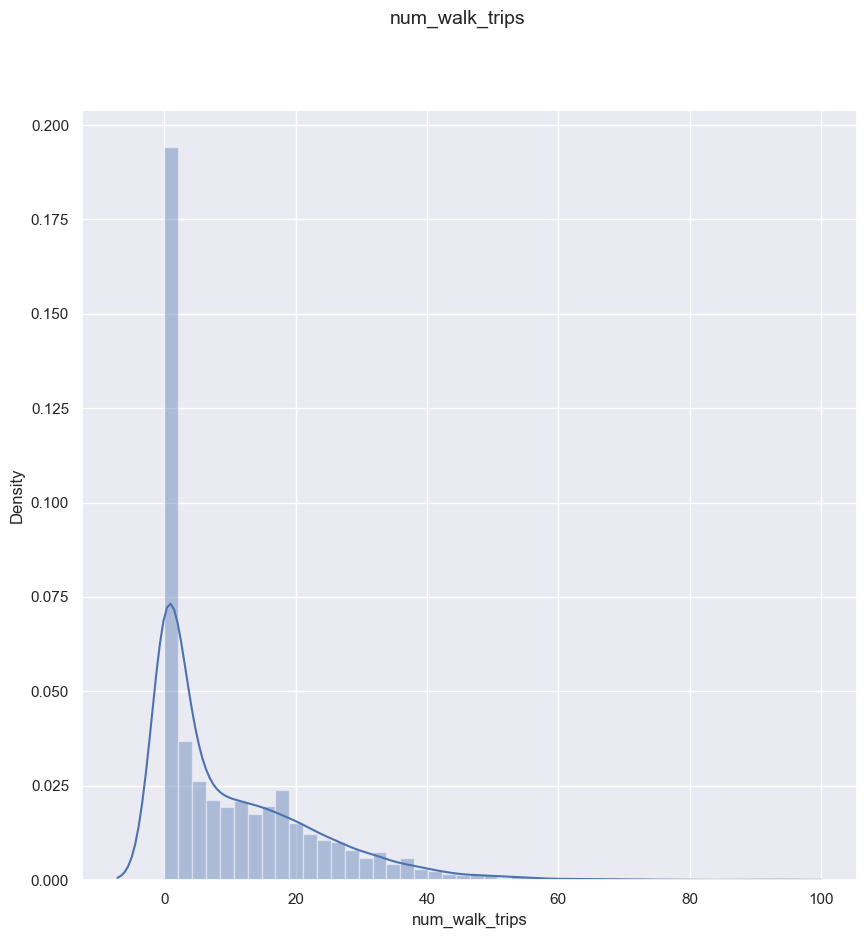

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


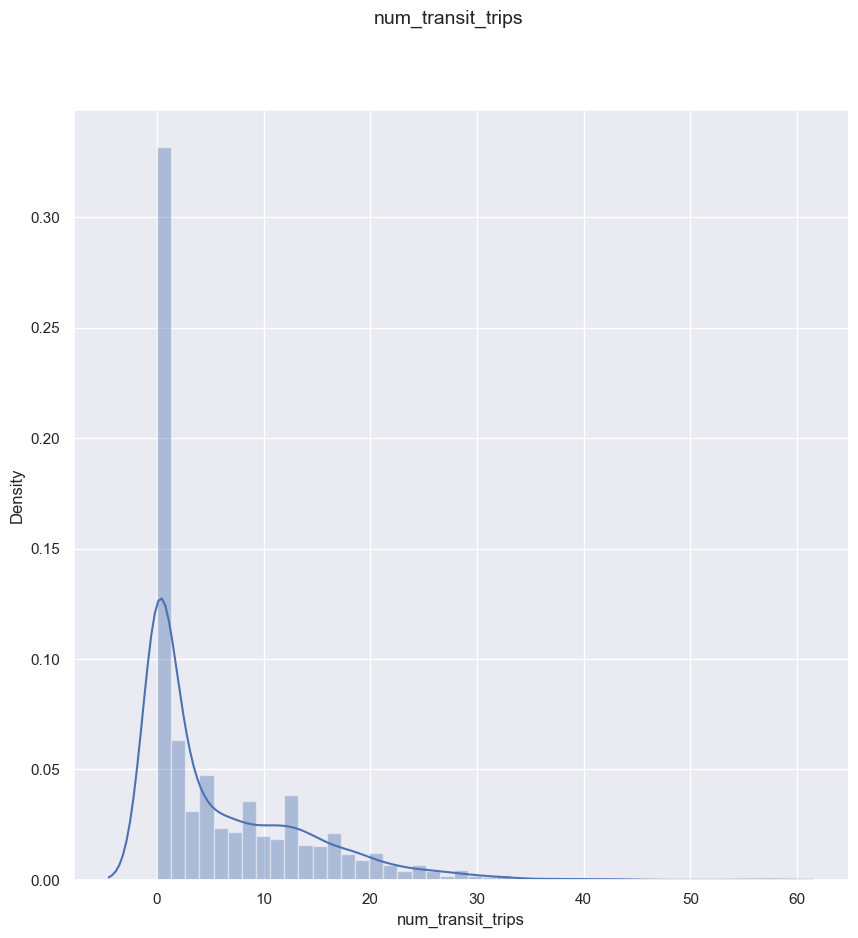

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


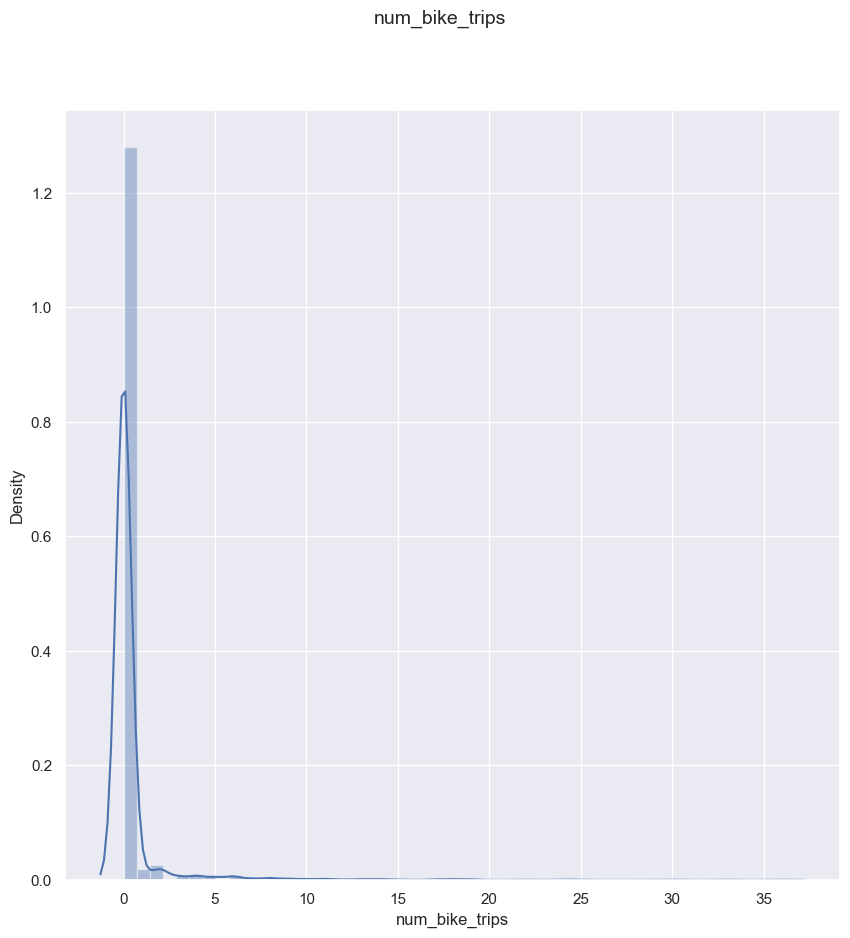

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


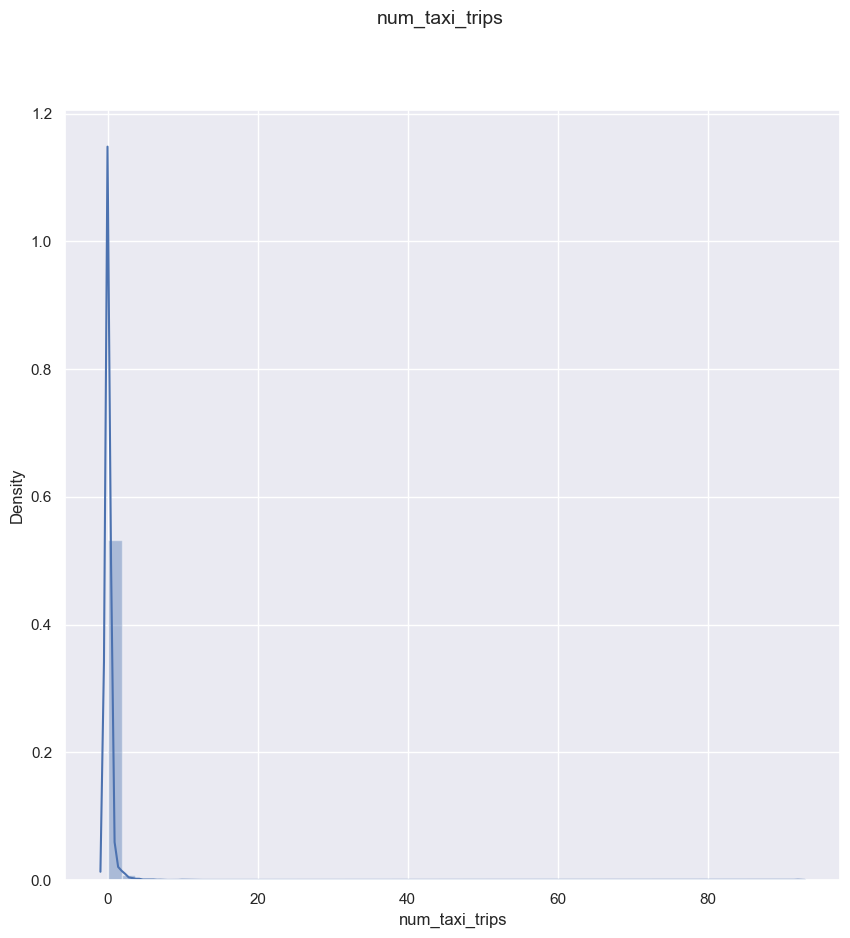

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


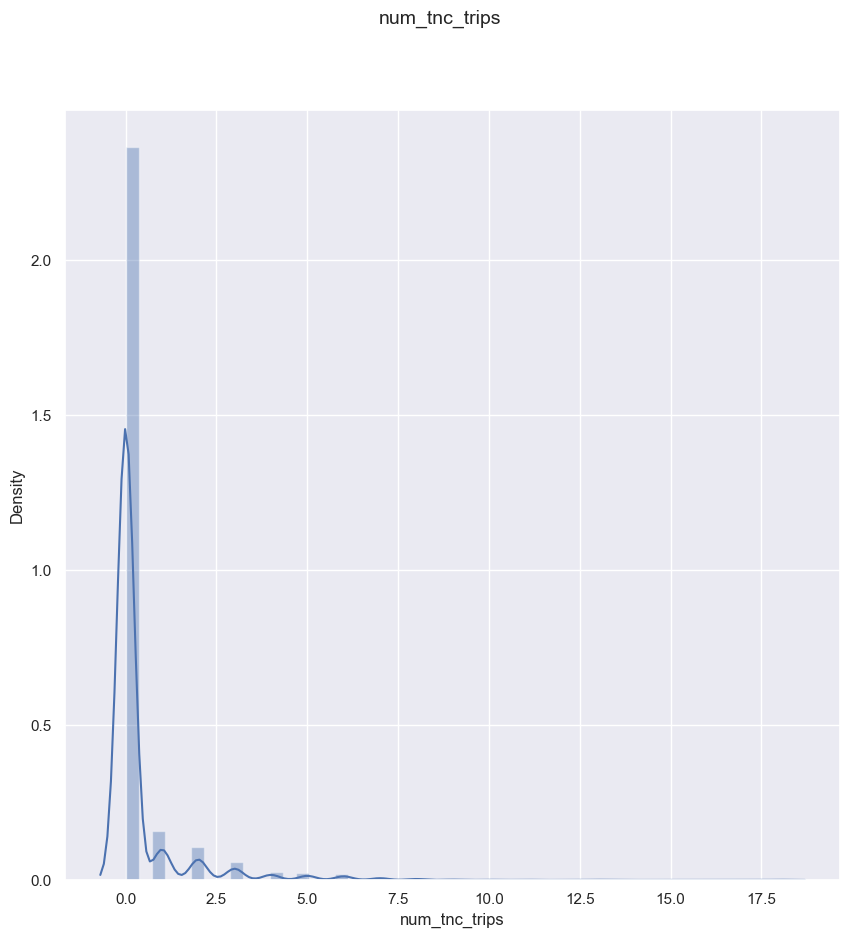

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


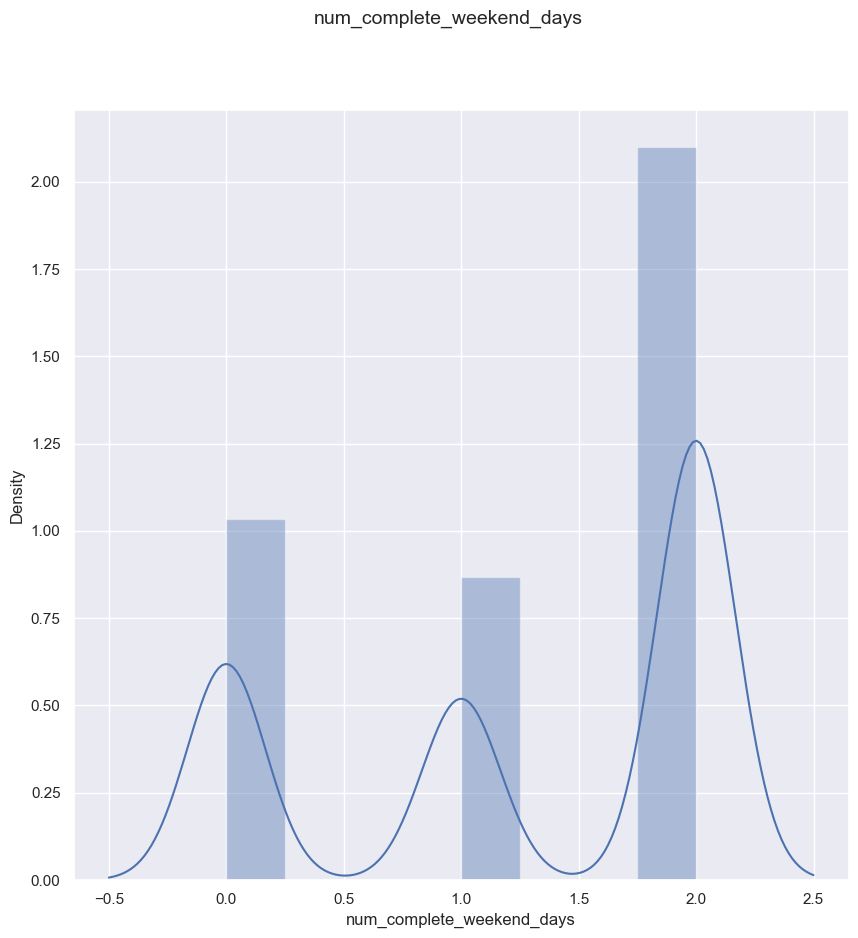

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


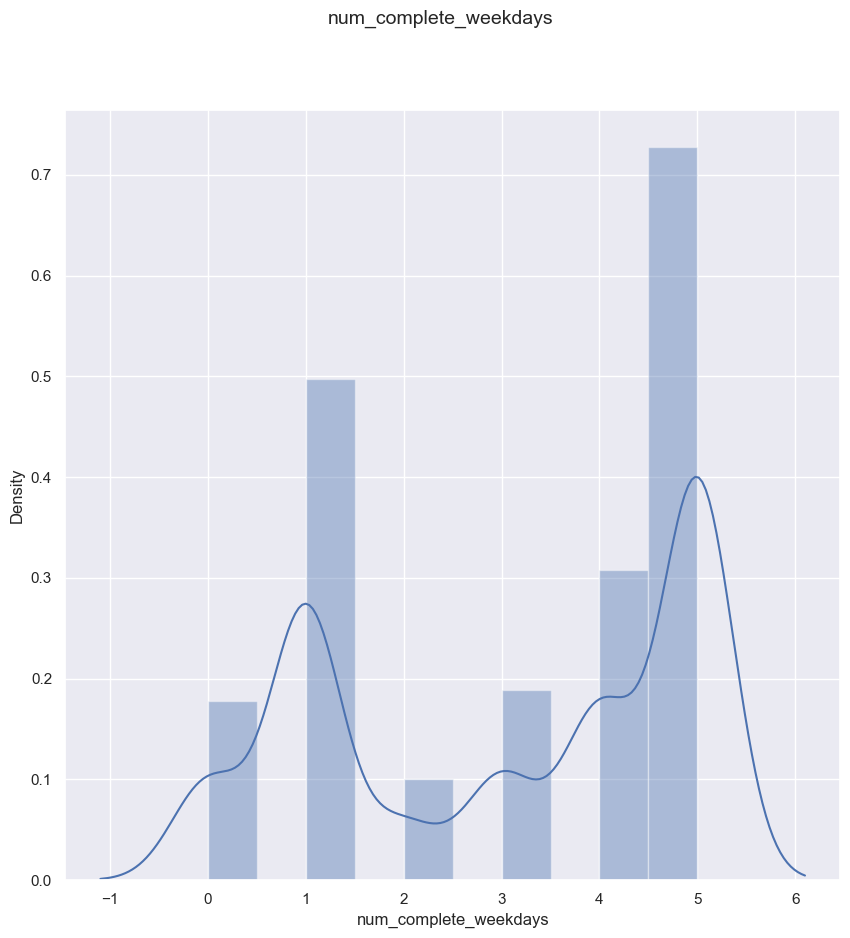

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


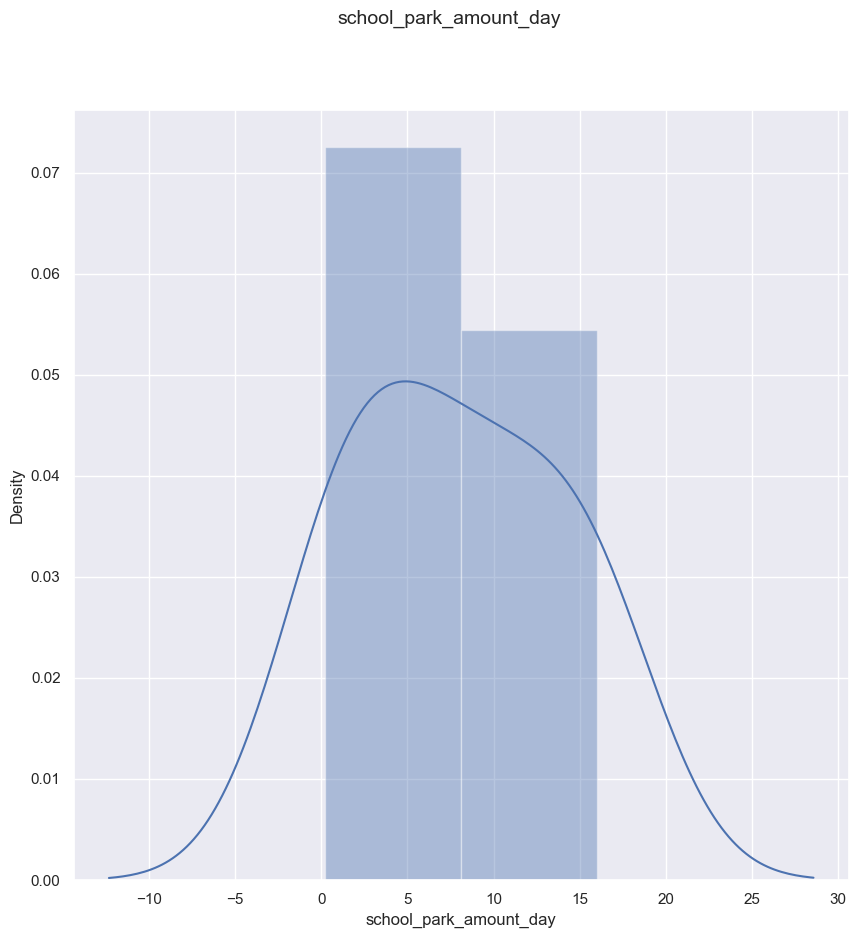

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


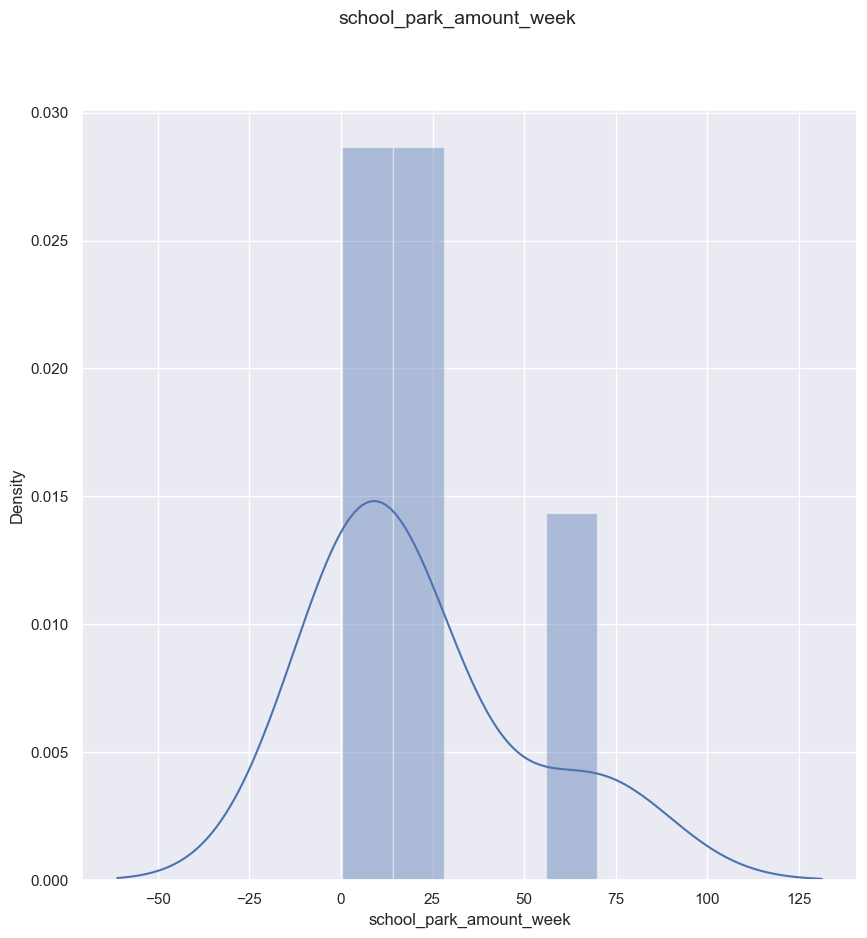

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


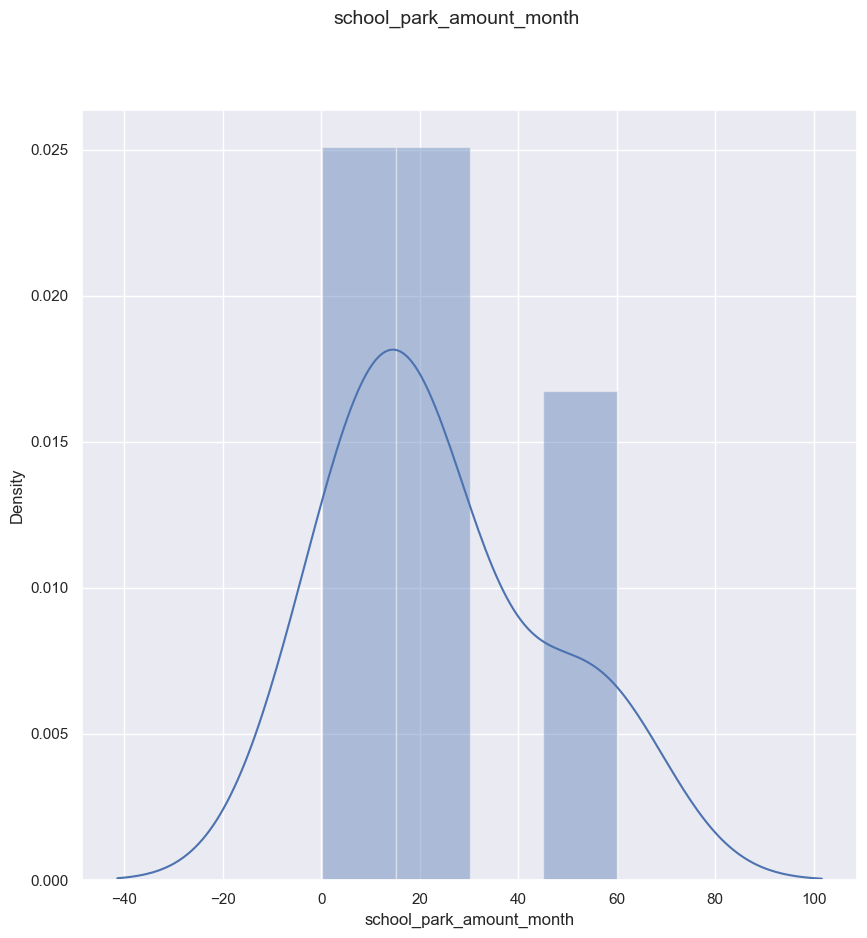

C:\Users\nasser\AppData\Local\Temp\ipykernel_13616\2257759361.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], ax=ax)


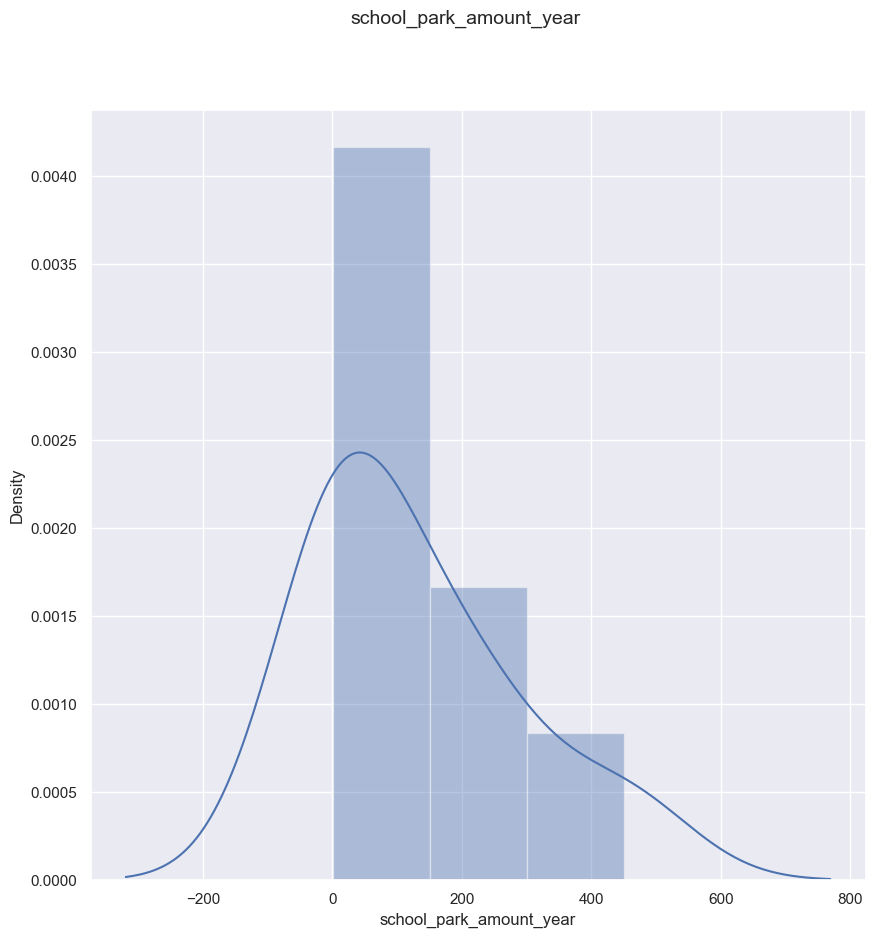

In [550]:
#plots help us to decide what to do in feature engineering
def plots_(data,feature): 
        fig, ax = plt.subplots(1, figsize=(10,10), sharey=True)
        fig.suptitle(feature, fontsize=14)
        sns.distplot(data[feature], ax=ax)
        plt.show()

for column in numerical_data:
    feature=plots_(numerical_data, column)

##### skewed data such as ['num_walk_trips', 'num_transit_trips','num_bike_trips','num_taxi_trips','num_tnc_trips'] will be log transformed to reduce skewness before scaling
##### bimodal distribution ['num_trips','school_park_amount_weak' ,'school_park_amount_month'] normalization or standardization can be applied 
##### multimodal distribution ['num_complete_weekdays', 'num_complete_weekend_days'] normalization or standardization can be applied

# Missing Values

convert the -9998 value to NaN to handle it also with missing values

In [551]:
for column in data.columns:
    data[column] = data[column].replace(-9998,np.nan)
    data[column] = data[column].replace("-9998",np.nan)

compute the percentage of null values of each column

In [552]:
null_percentage = data.isna().sum().apply(lambda x:x/data.shape[0]*100).sort_values(ascending=False)[data.isna().sum()>0] 

<AxesSubplot: >

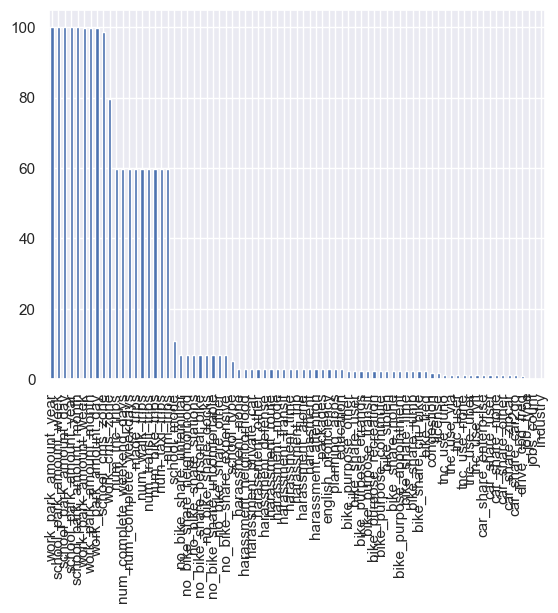

In [553]:
null_percentage.plot(kind='bar')

remove any column have more than 50% NULL

In [554]:
print(f"before Remove  {data.shape}")
data.drop(columns=null_percentage[null_percentage>50].index.to_list(),inplace=True)
print(f"after Remove  {data.shape}")


before Remove  (8286, 156)
after Remove  (8286, 137)


for the rest we will remove any row have null value

In [555]:
print(f"before Remove  {data.shape}")
data = data.dropna(axis=0)
print(f"after Remove  {data.shape}")
# Fill data having null percentage less than 50% with mode(), as most of the data are nominal  
# # Fill null data
# def fill_null_values(dataframe):
#     for column in dataframe:
#         dataframe[column].fillna(dataframe[column].mode()[0],inplace=True)
#     return dataframe
# data = fill_null_values(data)

before Remove  (8286, 137)
after Remove  (6728, 137)


remove any row have is_participant value not 1 becouse all the rest of the values are null

In [556]:
print(f"before Remove  {data.shape}")
data = data[data["is_participant"]==1]
print(f"after Remove  {data.shape}")

before Remove  (6728, 137)
after Remove  (2692, 137)


# Encoding Features

In [557]:
with open("data/columns_encoding.json") as file:
    columns_dictionary = json.loads(file.read()) # read the file as string and convert it to dictionary

In [558]:
columns_dictionary

{'survey_mode': {'1': 'rMove',
  '2': 'rSurvey',
  '3': 'Call center',
  '995': 'skip logic'},
 'is_participant': {'0': 'Not selected', '1': 'Selected', '995': 'skip logic'},
 'made_trips': {'0': 'Not selected', '1': 'Selected', '995': 'skip logic'},
 'relationship': {'0': 'Self',
  '1': 'Spouse or partner',
  '2': 'Son or daughter',
  '3': 'Father or mother',
  '4': 'Brother or sister',
  '5': 'Other relative',
  '6': 'Roommate or friend',
  '7': 'Household help',
  '995': 'skip logic'},
 'age': {'1': 'Under 5',
  '2': '5-15',
  '3': '16-17',
  '4': '18-24',
  '5': '25-34',
  '6': '35-44',
  '7': '45-54',
  '8': '55-64',
  '9': '65-74',
  '10': '75-84',
  '11': '85 or older',
  '995': 'skip logic'},
 'employment': {'1': 'Employed full-time',
  '2': 'Employed part-time',
  '3': 'Primarily self-employed',
  '6': 'Not currently employed',
  '7': 'Unpaid volunteer or intern',
  '995': 'skip logic'},
 'worker': {'0': 'Not employed', '1': 'Employed', '995': 'skip logic'},
 'student': {'0': 

In [559]:
unique_zones_values = data['cms_zone'].unique()
res_dct = {zone:zone for zone in  unique_zones_values }
res_dct

{'Inner Brooklyn': 'Inner Brooklyn',
 'Middle Queens': 'Middle Queens',
 'Outer Queens': 'Outer Queens',
 'Manhattan Core': 'Manhattan Core',
 'Northern Bronx': 'Northern Bronx',
 'Staten Island': 'Staten Island',
 'Northern Manhattan': 'Northern Manhattan',
 'Inner Queens': 'Inner Queens',
 'Outer Brooklyn': 'Outer Brooklyn',
 'Southern Bronx': 'Southern Bronx'}

In [560]:
columns_dictionary['cms_zone'] = res_dct

for each column_name in the dictionary encode the data using the dictionary values to create one_hot_encoding

In [561]:
for column_name in columns_dictionary:
    data = one_hot_encoding(data=data,column=column_name,dictionary=columns_dictionary[column_name])

In [562]:
data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [563]:
data.select_dtypes(include='object').columns # will handle it later

Index([], dtype='object')

select numberic features only to apply kmeans on them

In [564]:
numeric_fetures = data.select_dtypes(include=np.number).columns.tolist()
data_numeric = data[numeric_fetures]
data_numeric.shape

(2692, 295)

apply Standard Scaler on the Data

In [565]:
data_numeric_standarized = StandardScaler().fit_transform(data_numeric)
data_numeric_standarized = pd.DataFrame(data_numeric_standarized, columns = data_numeric.columns)
data_numeric_standarized.head()
# data_numeric_standarized = data_numeric

,smartphone_type,jobs_count,bike_num_days,survey_mode_Call center,survey_mode_rMove,survey_mode_rSurvey,is_participant_Selected,age_18-24,age_25-34,age_35-44,...,cms_zone_Inner Brooklyn,cms_zone_Inner Queens,cms_zone_Manhattan Core,cms_zone_Middle Queens,cms_zone_Northern Bronx,cms_zone_Northern Manhattan,cms_zone_Outer Brooklyn,cms_zone_Outer Queens,cms_zone_Southern Bronx,cms_zone_Staten Island
0,-0.507334,1.449614,-1.182246,-0.252213,0.679305,-0.586502,0.0,-0.274007,1.998608,-0.491045,...,3.402858,-0.313572,-0.287861,-0.329745,-0.387216,-0.30492,-0.333883,-0.359437,-0.348137,-0.365993
1,0.873600,-0.690243,-1.186326,-0.252213,0.679305,-0.586502,0.0,-0.274007,1.998608,-0.491045,...,-0.293871,-0.313572,-0.287861,3.032651,-0.387216,-0.30492,-0.333883,-0.359437,-0.348137,-0.365993
2,0.873600,-0.690243,-1.186326,-0.252213,0.679305,-0.586502,0.0,-0.274007,-0.500348,-0.491045,...,-0.293871,-0.313572,-0.287861,3.032651,-0.387216,-0.30492,-0.333883,-0.359437,-0.348137,-0.365993
3,0.873600,-0.690243,-1.176126,-0.252213,0.679305,-0.586502,0.0,-0.274007,1.998608,-0.491045,...,-0.293871,-0.313572,-0.287861,3.032651,-0.387216,-0.30492,-0.333883,-0.359437,-0.348137,-0.365993
4,-0.507334,-0.688090,0.843432,-0.252213,0.679305,-0.586502,0.0,-0.274007,1.998608,-0.491045,...,-0.293871,-0.313572,-0.287861,-0.329745,-0.387216,-0.30492,-0.333883,2.782132,-0.348137,-0.365993


# Hyper Parameter Tuning

finding the optimal k using elbow

In [566]:
result = []
potential_k = list(range(2, 21))
for k in potential_k:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data_numeric_standarized)
  result.append(kmeans.inertia_)

In [567]:
result[1:5]

[716993.0381207232, 699369.5506499948, 684065.6789610328, 676743.5326838921]

In [568]:
optimal_k_elbow = result[1:5].index(min(result[1:5]))+1

finding the optimal k using silhouette_score

In [569]:
sil = []
kmax = 20
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(data_numeric_standarized)
  labels = kmeans.labels_
  sil.append(silhouette_score(data_numeric_standarized, labels, metric = 'euclidean'))

In [570]:
result = [value/10000 for value in result]

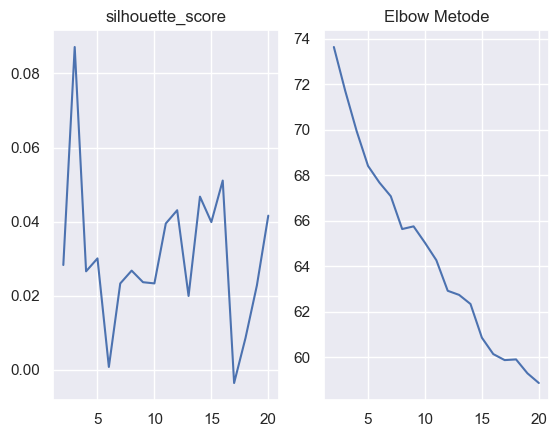

In [571]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(2,kmax+1),sil)
ax2.plot(potential_k, result)
ax1.set_title('silhouette_score')
ax2.set_title('Elbow Metode')
plt.show()

In [572]:
optimal_k_sil = sil.index(max(sil))+2

In [573]:
print(f"optimal K using elbow : {optimal_k_elbow}")
print(f"optimal K using silh : {optimal_k_sil}")

optimal K using elbow : 4
optimal K using silh : 3


# Modeling

train the model with the optimal_k value 

In [574]:
kmeans_sil = KMeans(n_clusters=optimal_k_sil)
y_kmeans_sil = kmeans_sil.fit_predict(data_numeric_standarized)
centers_sil = kmeans_sil.cluster_centers_
#---#
kmeans_elbow = KMeans(n_clusters=optimal_k_elbow)
y_kmeans_elbow = kmeans_elbow.fit_predict(data_numeric_standarized)
centers_elbow = kmeans_elbow.cluster_centers_

# Evaluating

use PCA to reduce the dimentions of the data to plot it in 2d space

In [575]:
pca_model = PCA(n_components = 2)
pca_model.fit(data_numeric_standarized)

PCA(n_components=2)

In [576]:

training_data_pca = pca_model.transform(data_numeric_standarized)
centers_elbow_pca = pca_model.transform(centers_elbow)
centers_sil_pca = pca_model.transform(centers_sil)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


draw the data in 2d space

Text(0.5, 1.0, 'kmeans approuch')

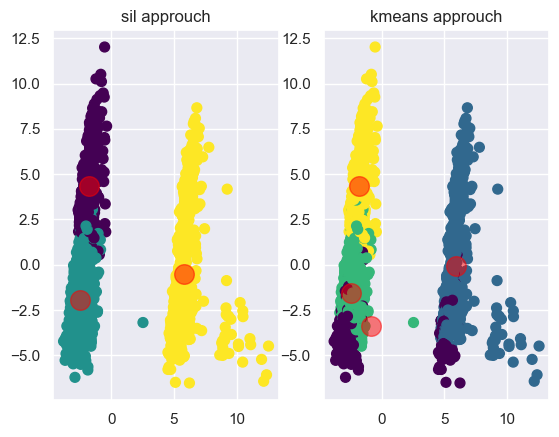

In [577]:

figure, axis = plt.subplots(1, 2)
axis[0].scatter(training_data_pca[:, 0],
            training_data_pca[:, 1], c=y_kmeans_sil, s=50, cmap='viridis')
axis[0].scatter(centers_sil_pca[:, 0], centers_sil_pca[:, 1], c='red', s=200, alpha=0.5)
axis[1].scatter(training_data_pca[:, 0],
            training_data_pca[:, 1], c=y_kmeans_elbow, s=50, cmap='viridis')
axis[1].scatter(centers_elbow_pca[:, 0], centers_elbow_pca[:, 1], c='red', s=200, alpha=0.5)

axis[0].set_title("sil approuch")
axis[1].set_title("kmeans approuch")

In [578]:
import umap.umap_ as umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric_standarized)
training_data_embedding = umap_model.transform(data_numeric_standarized)
centers_sil_embedding = umap_model.transform(centers_sil)
centers_elbow_embedding = umap_model.transform(centers_elbow)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0.5, 1.0, 'kmeans approuch')

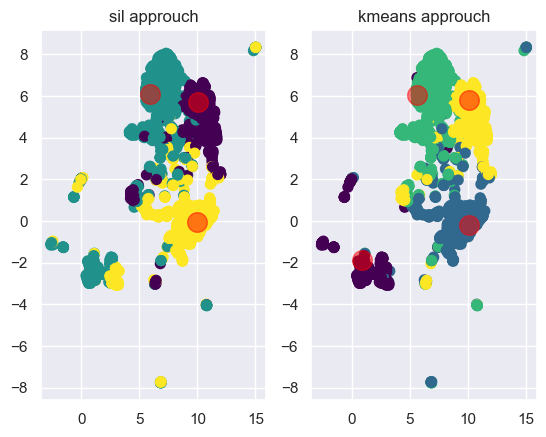

In [579]:

figure, axis = plt.subplots(1, 2)
axis[0].scatter(training_data_embedding[:, 0],
            training_data_embedding[:, 1], c=y_kmeans_sil, s=50, cmap='viridis')
axis[0].scatter(centers_sil_embedding[:, 0], centers_sil_embedding[:, 1], c='red', s=200, alpha=0.5)
axis[1].scatter(training_data_embedding[:, 0],
            training_data_embedding[:, 1], c=y_kmeans_elbow, s=50, cmap='viridis')
axis[1].scatter(centers_elbow_embedding[:, 0], centers_elbow_embedding[:, 1], c='red', s=200, alpha=0.5)

axis[0].set_title("sil approuch")
axis[1].set_title("kmeans approuch")

For n_clusters = 2 The average silhouette_score is : 0.10713664961391096
For n_clusters = 3 The average silhouette_score is : 0.016217003785832566
For n_clusters = 4 The average silhouette_score is : 0.026540748265986926
For n_clusters = 5 The average silhouette_score is : 0.023870808742295416
For n_clusters = 6 The average silhouette_score is : 0.0234479905320868
For n_clusters = 7 The average silhouette_score is : 0.023203956494878334
For n_clusters = 8 The average silhouette_score is : 0.03771820777904506
For n_clusters = 9 The average silhouette_score is : 0.014850533454419826


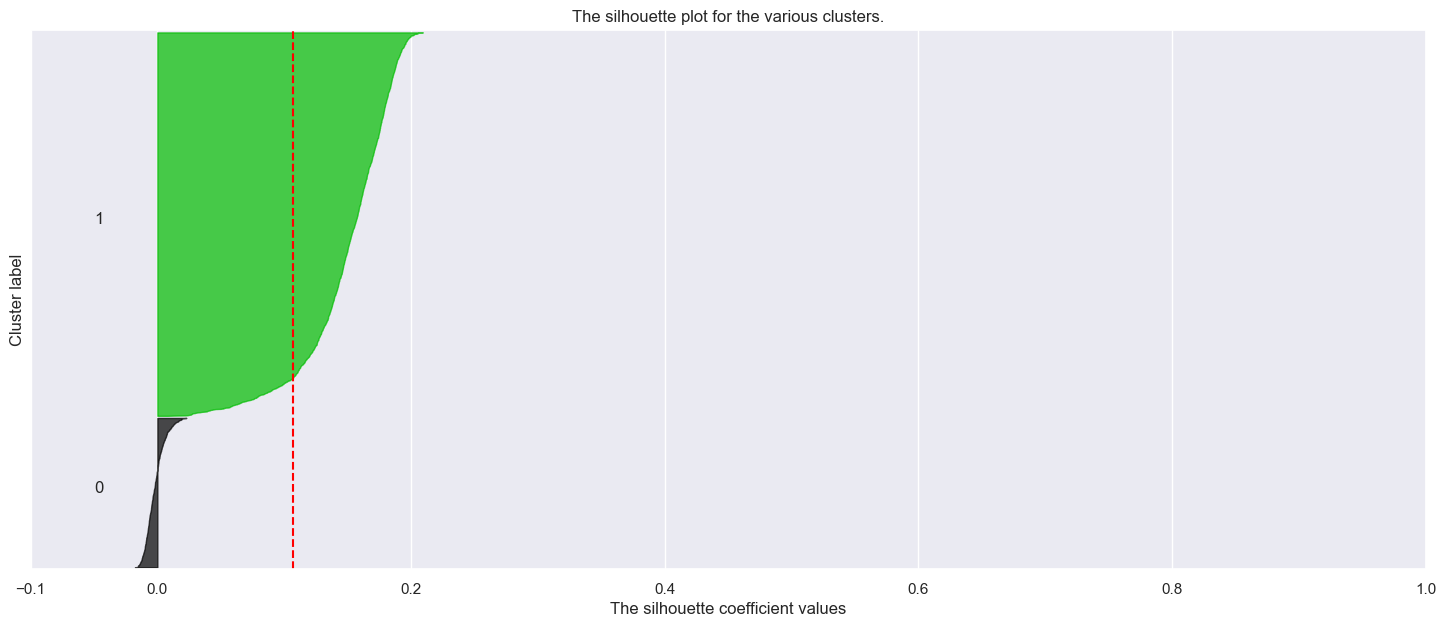

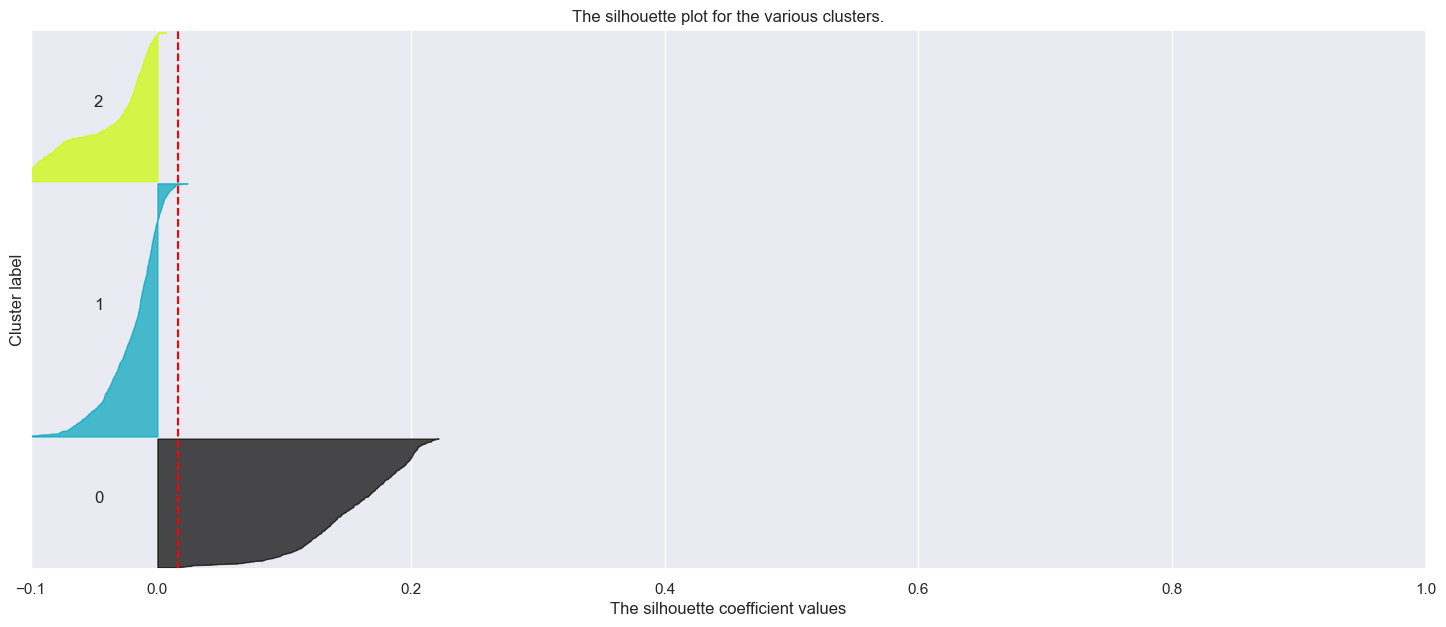

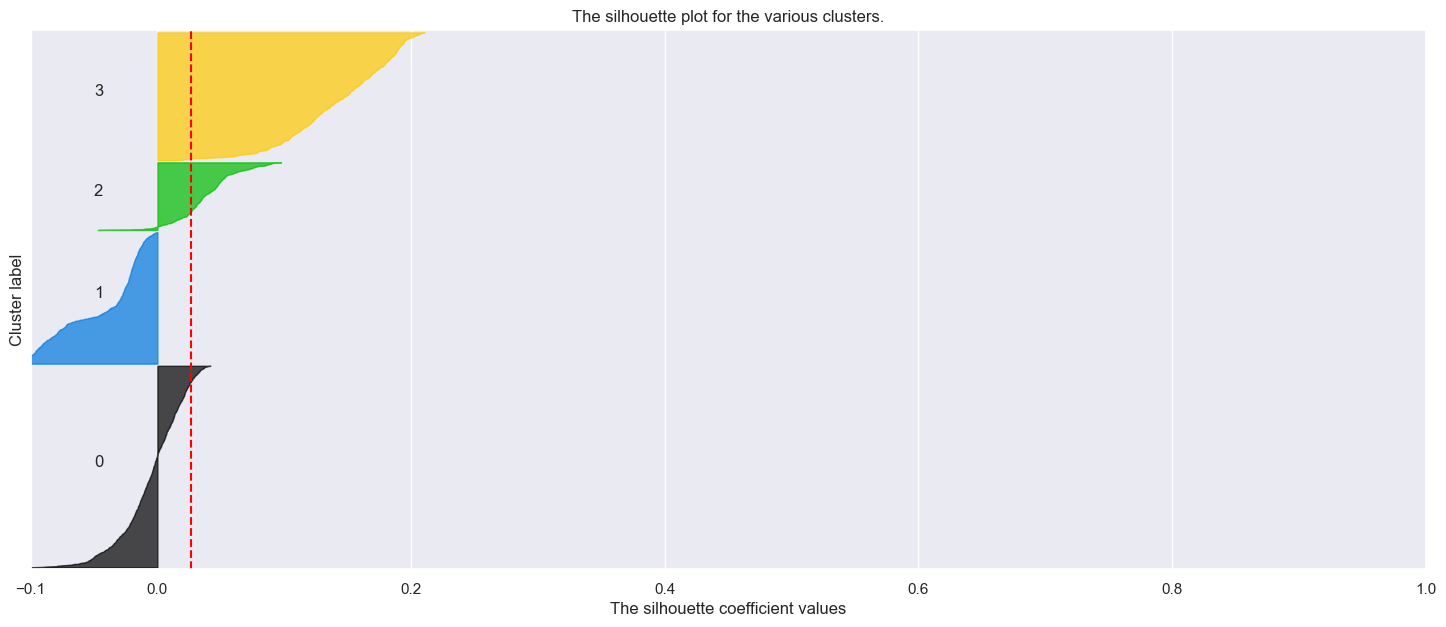

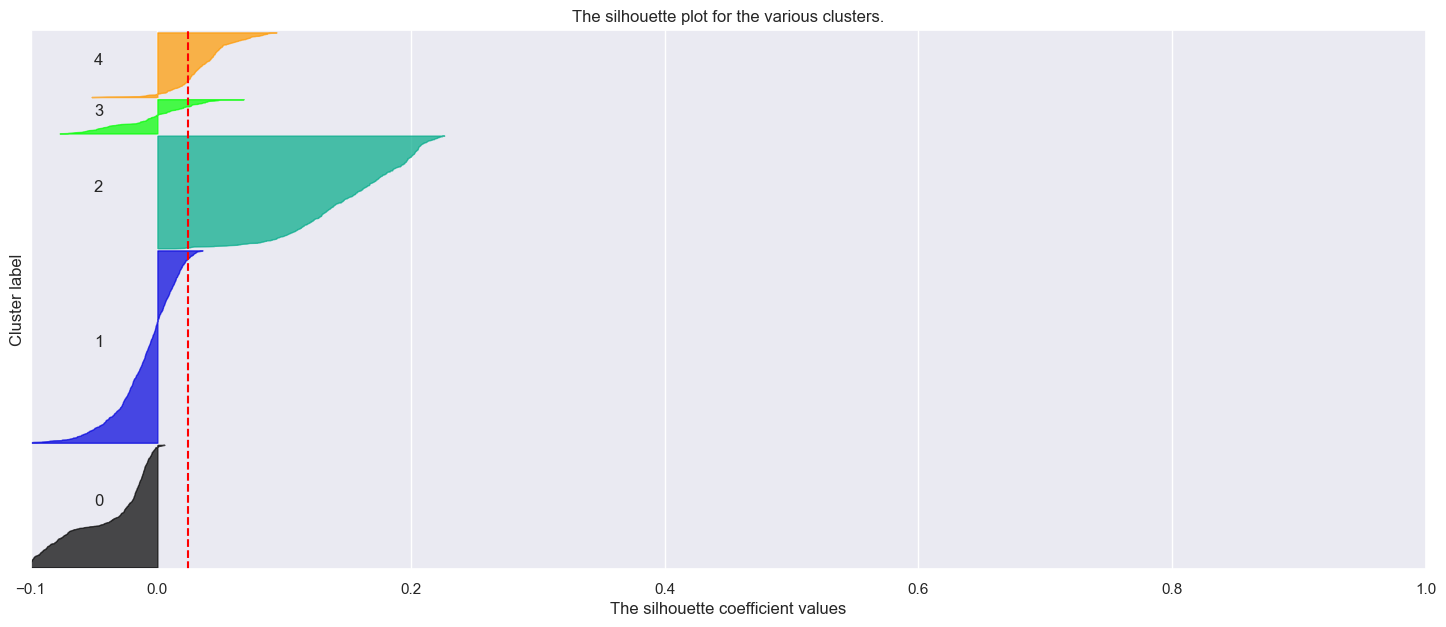

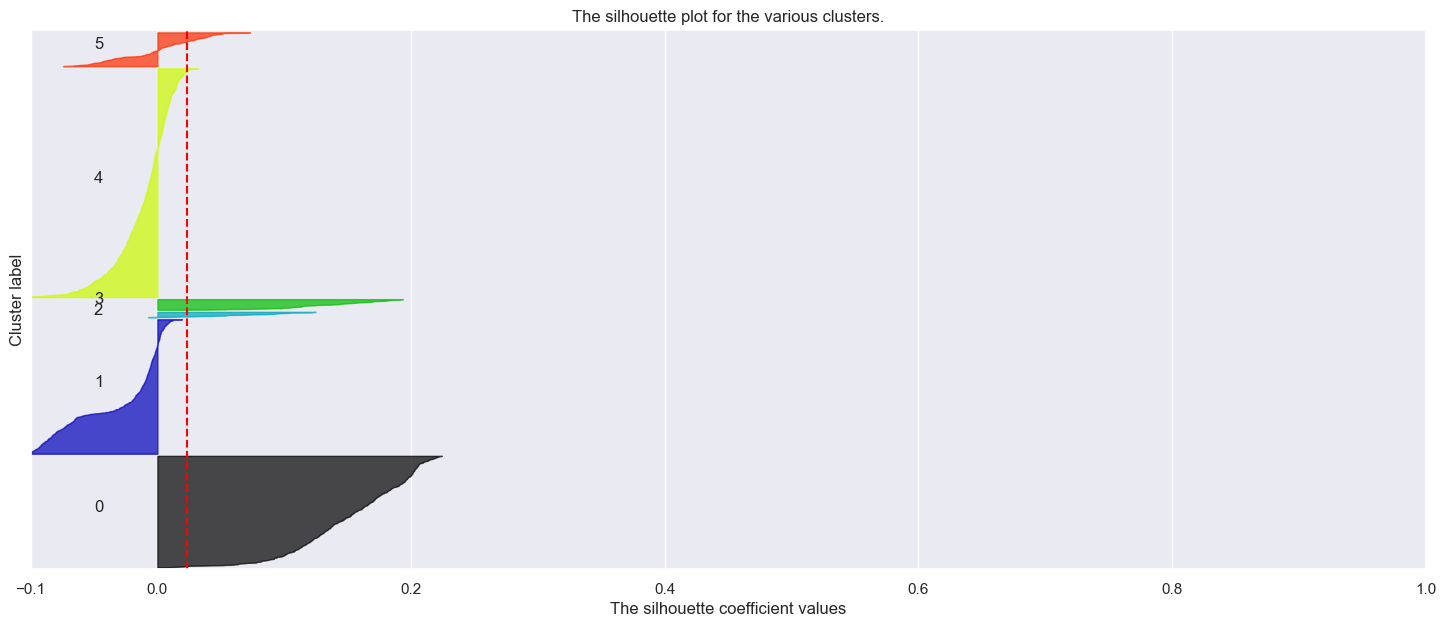

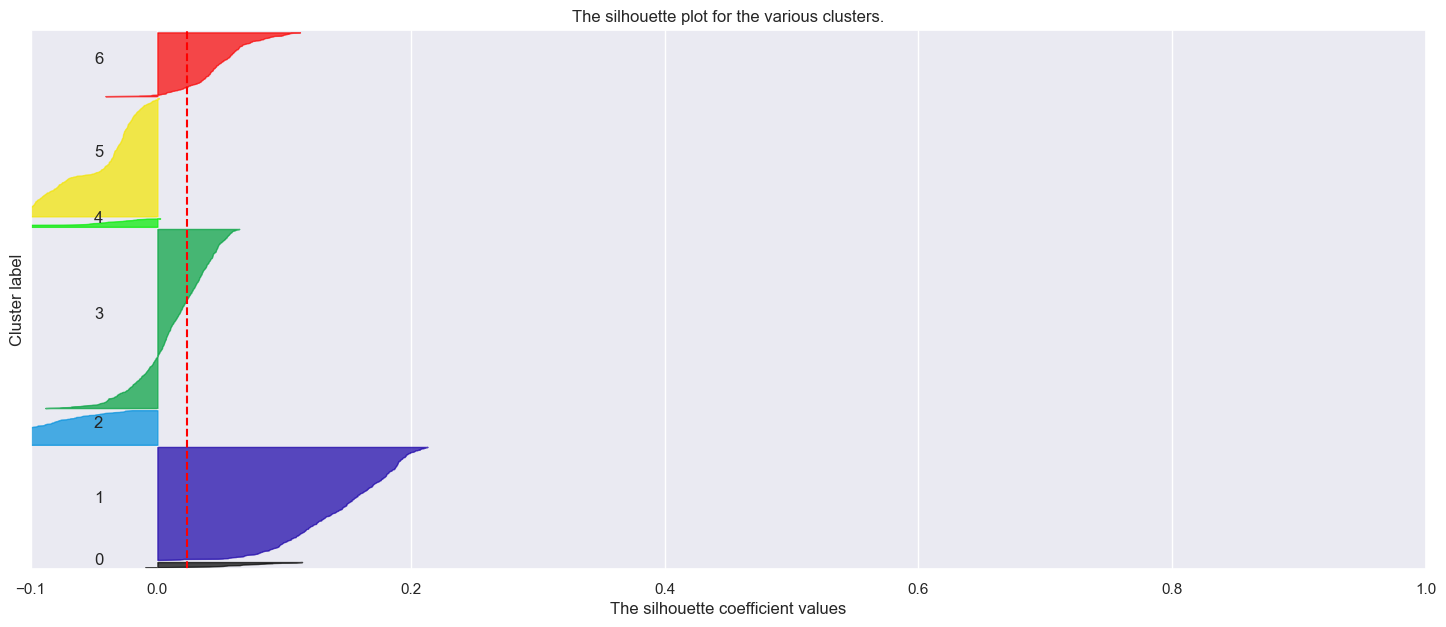

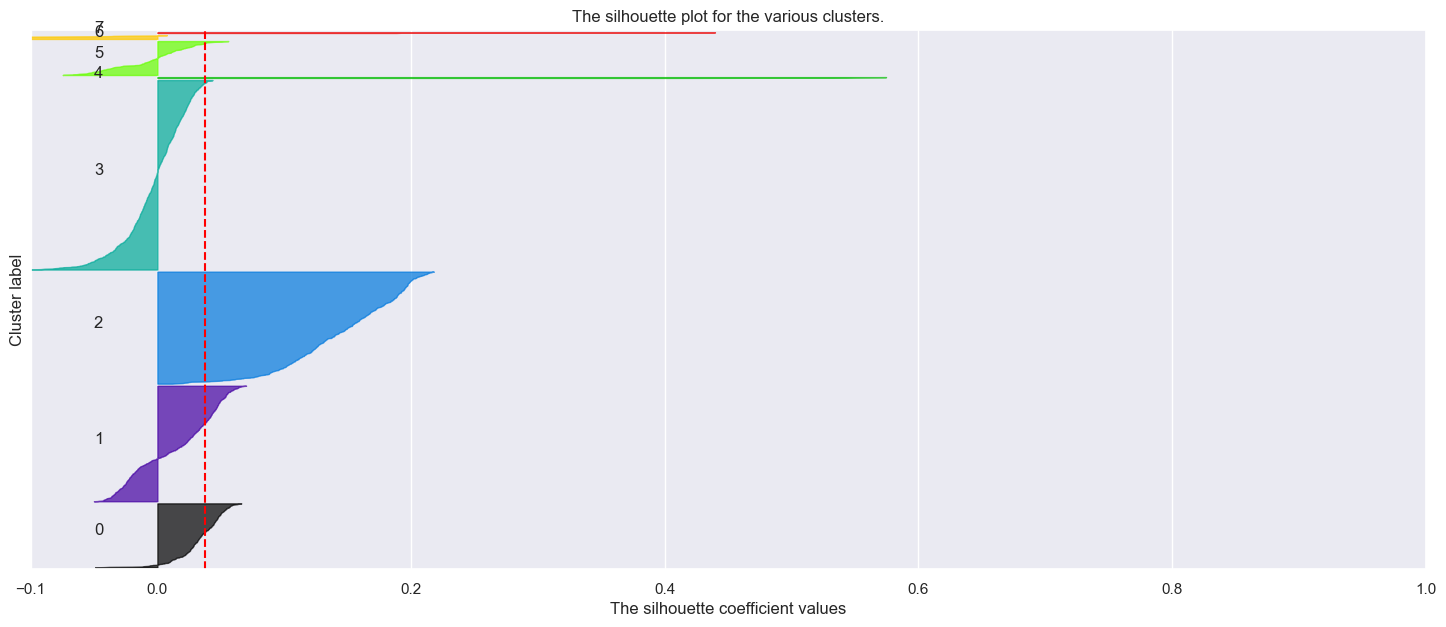

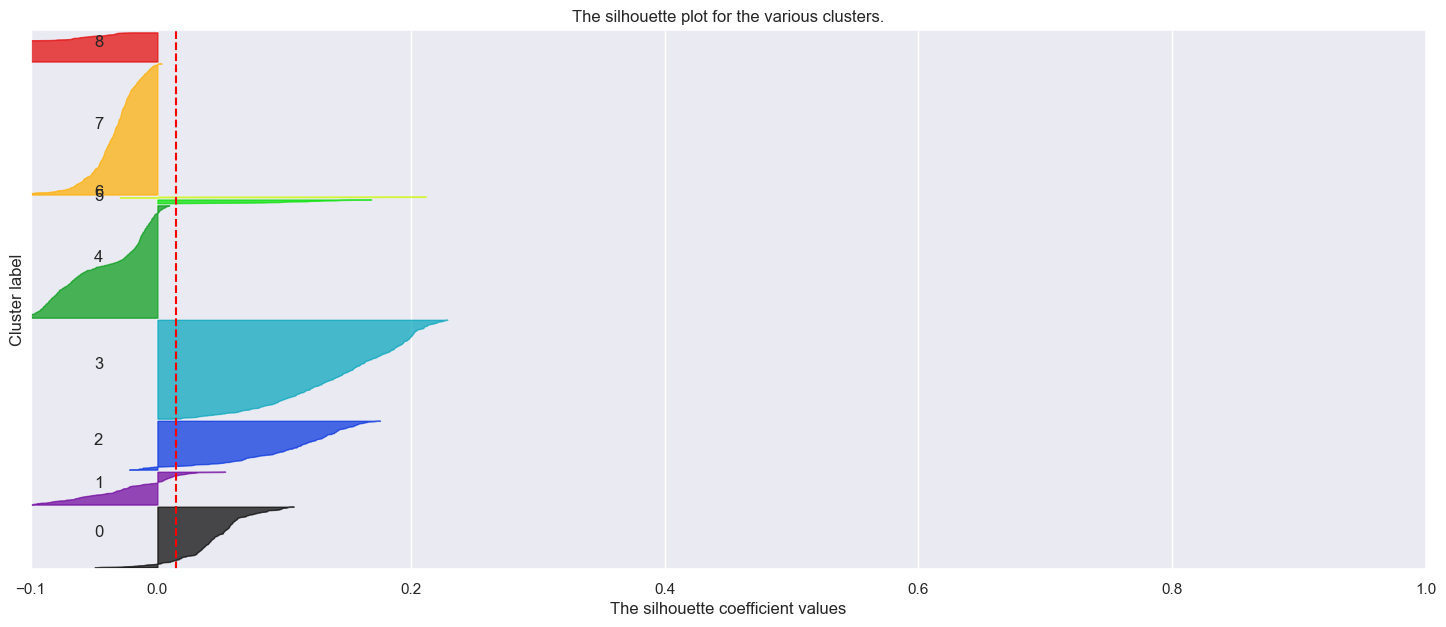

In [580]:
import matplotlib.cm as cm
potential_k = list(range(2, 10))
for n_clusters in potential_k:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_numeric_standarized) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_numeric_standarized)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_numeric_standarized, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_numeric_standarized, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# K-Means Analysis

In [581]:
data_numeric_mohammad = data_numeric.copy()
data_numeric_mohammad['label'] = y_kmeans_elbow

# label 0

In [582]:
variances = data_numeric_mohammad.var()
zero_variances = variances[variances == 0].index
data_numeric_mohammad = data_numeric_mohammad.drop(zero_variances, axis=1)

In [583]:
label_0_data = data_numeric_mohammad[data_numeric_mohammad['label']==0]

In [584]:
label_0_data.to_csv("data/kmeans_label_0.csv")

In [585]:
label_0_variance = data_numeric_mohammad[data_numeric_mohammad['label']==0].var().sort_values()
count = 0
for i in label_0_variance[label_0_variance==0].index:
    print(f"{i}          ",end="")
    count +=1
    if count %10:
        count = 0
        print()

    

school_bike_park_skip logic          
work_bike_park_Other          
work_bike_park_Secured bike room          
work_bike_park_skip logic          
school_mode_own_HH vehicle 2          
school_mode_own_Other vehicle in household          
school_mode_auto_Car from work          
school_mode_auto_Carpool          
work_bike_park_Locked to other object          
school_mode_auto_Other vehicle          
school_mode_bus_Intercity bus          
school_mode_bus_Other private          
school_mode_bus_School bus          
school_mode_bus_Select Bus Service          
school_mode_rail_Commuter rail          
school_mode_rail_Other rail           
school_mode_rail_PATH train          
school_mode_auto_skip logic          
work_bike_park_In a parking          
work_bike_park_Bike-share designated docking station          
work_bike_park_Bike rack          
work_mode_rail_Commuter rail          
work_mode_rail_Intercity rail          
work_mode_rail_Other rail          
work_mode_rail_PATH train 

In [586]:
label_0_data.shape

(345, 288)

In [587]:
column_name = "age_35-44"
print(label_0_data[label_0_data[column_name]==1][column_name])
print(label_0_data[label_0_data[column_name]==1][column_name].count()/label_0_data.shape[0])

18      1
139     1
572     1
576     1
621     1
       ..
7679    1
7726    1
7781    1
7925    1
8083    1
Name: age_35-44, Length: 84, dtype: uint8
0.24347826086956523


* 99% of them do the servey from the mobile app 
* almost all the peapole in this cluster not in the age 18_24 -> adults 
* 80% are employment full time
* 0% not employed -> more power to the adults point
* 100% are workers with diffrenet types of work
* the majority not a students
* 0% a car share vehicle 
* 99% of them have a 1 or 2 or 3 private cars (vehicle)
* 100% of them go to work with private vehicle (work_mode_In a household vehicle)
* 60% of them use parking to park there cars and the 40% others use street
* 70% dont pay parking fee 
* all of them dont use bus or rail or any other ways of transportaion just private vihacle to go to work (work_mode_bus_skip logic)
* 50% of them are girls and 50% are mens theres a even split in gender
* 50% of them are whites and the 50% other distributed on different races

In [588]:
for i in label_0_data.sum().sort_values(ascending=False).index:
    print(i)

bike_num_days
smartphone_type
jobs_count
tnc_mode_bike_skip logic
worker_Employed
tnc_mode_scooter_skip logic
school_bike_park_skip logic
school_mode_bike_skip logic
school_mode_taxi_skip logic
school_mode_ferry_skip logic
jump_freq_skip logic
school_mode_auto_skip logic
work_mode_In a household vehicle
work_bike_park_skip logic
work_mode_bike_skip logic
work_mode_taxi_skip logic
work_mode_ferry_skip logic
work_mode_rail_skip logic
work_mode_bus_skip logic
work_mode_auto_skip logic
tnc_mode_ferry_skip logic
tnc_mode_auto_skip logic
lime_freq_skip logic
school_mode_rail_skip logic
school_mode_bus_skip logic
citi_bike_freq_skip logic
missing_school_location_No
tnc_mode_bus_skip logic
school_vehicle_pass_period_skip logic
school_park_location_skip logic
school_mode_own_skip logic
disability_mobility_Not selected
disability_seeing_Not selected
disability_dressing_Not selected
disability_concentrating_Not selected
disability_hearing_Not selected
disability_walking_Not selected
tnc_mode_rail

In [589]:
column_name = "bike_num_days"
label_0_data[column_name]

5         0
18      995
42      995
129     995
139       0
       ... 
8153      0
8166      1
8211    995
8219      0
8273    995
Name: bike_num_days, Length: 345, dtype: int64

In [590]:
label_1_data = data_numeric_mohammad[data_numeric_mohammad['label']==1]
label_1_data.to_csv("data/kmeans_label_1.csv")

In [591]:
label_1_data.shape

(672, 288)

In [592]:
column_name = "disability_walking_Selected"
print(label_1_data[label_1_data[column_name]==1][column_name].count()/label_1_data.shape[0])
print(label_1_data[label_1_data[column_name]==1][column_name])

0.10863095238095238
323     1
624     1
957     1
1000    1
1110    1
       ..
7970    1
8180    1
8213    1
8247    1
8268    1
Name: disability_walking_Selected, Length: 73, dtype: uint8


* 50% of them do the servey from the mobile app and the rest from the browser or call centers
* most of the people in this cluster are in age between 35 - 60 ("age_35-44","age_75-84","age_55-64","age_45-54)
* 95% of the people not currently employeed (employment_Not currently employed,worker_Not employed)
* most of them are not students (student_Not a student)
* more than half of them dont have vehicle 
* 60% of them females , 40% males (gender_Female,gender_Male)
* 25% of them are black (race_Balck_Selected)
* 50% of them are White(race_white_Selected)
* 15% of them have walking disability (disability_hearing_Selected)  and theres a 20% additional people have other disabilities

In [593]:
label_2_data = data_numeric_mohammad[data_numeric_mohammad['label']==2]
label_2_data.to_csv("data/kmeans_label_2.csv")

In [594]:
label_2_data.shape

(1024, 288)

In [595]:
column_name = "disability_dressing_Selected"
print(label_2_data[label_2_data[column_name]==1][column_name].count()/label_2_data.shape[0])
print(label_2_data[label_2_data[column_name]==1][column_name])

0.001953125
2187    1
7911    1
Name: disability_dressing_Selected, dtype: uint8


* 60% of them have Iphone  (smartphone_type ==2)
* people age are distibuted evenly between 24 - 74  (also adults)
* 75% are a full time employees 15% are part time and the rest are others 
* 100% of them are employees (worker_Employed)
* not a students
* 28% of them have a private vehicle
* 15% go to work using bus or shuttle
* 60% go to work using rail
* 60% females and 40% males
* 50% of them are white and 18% are black
* 60% of them use subways


In [596]:
label_3_data = data_numeric_mohammad[data_numeric_mohammad['label']==3]
label_3_data.to_csv("data/kmeans_label_3.csv")

In [597]:
label_3_data.shape

(651, 288)

In [598]:
column_name = "race_white_Selected"
print(label_3_data[label_3_data[column_name]==1][column_name].count()/label_3_data.shape[0])
print(label_3_data[label_3_data[column_name]==1][column_name])

0.47465437788018433
37      1
83      1
293     1
375     1
392     1
       ..
8207    1
8226    1
8231    1
8235    1
8250    1
Name: race_white_Selected, Length: 309, dtype: uint8


* 60% employees 40% are not emplyees 
* 41% have private car
* 30% use reils to go to work
* 50% females , 50% males
* 50% white  15% black

# DBSCAN 
Hyperparamters used: 
* "eps": specifies the maximum distance between two points to be considered neighbors and part of the same cluster
* "min_samples": specifies the minimum number of points required for a group of points to be considered a cluster
* "metric": clustering evaluation metric

Hyper Parameter Tuning

finding the optimal eps, and min_samples using silhouette_score


In [599]:
array_data_numeric_standarized = np.array(data_numeric_standarized)
array_data_numeric_standarized

array([[-0.50733435,  1.44961378, -1.18224563, ..., -0.35943655,
        -0.34813719, -0.36599336],
       [ 0.87359999, -0.69024296, -1.18632554, ..., -0.35943655,
        -0.34813719, -0.36599336],
       [ 0.87359999, -0.69024296, -1.18632554, ..., -0.35943655,
        -0.34813719, -0.36599336],
       ...,
       [ 2.25453433, -0.69024296,  0.84343231, ..., -0.35943655,
        -0.34813719,  2.73229003],
       [-1.88826868, -0.69024296,  0.84343231, ..., -0.35943655,
        -0.34813719,  2.73229003],
       [-1.88826868, -0.69024296, -1.18632554, ..., -0.35943655,
        -0.34813719,  2.73229003]])

K = 2

In [600]:
# determine the best value for eps with k=2
k=2
neighbor = NearestNeighbors(n_neighbors=k)
neighbors = neighbor.fit(array_data_numeric_standarized)
distances, indices = neighbors.kneighbors(array_data_numeric_standarized)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

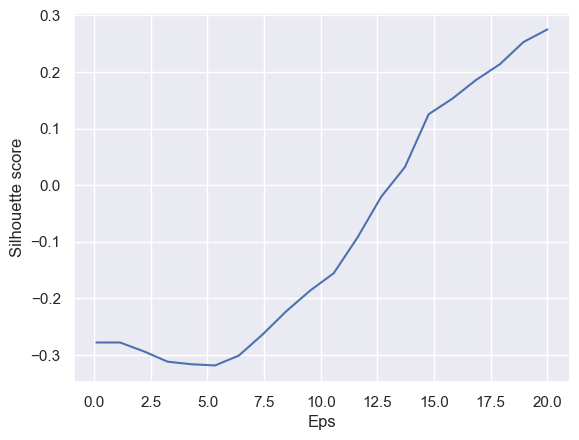

In [601]:
# Choose a range of eps values to try
eps_range = np.linspace(0.1, 20.0, num=20)

# Evaluate DBSCAN with different values of eps
silhouette_scores = []
for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=k)
    dbscan.fit(array_data_numeric_standarized)
    if len(set(dbscan.labels_)) > 1: # check if there is more than one cluster
        silhouette_scores.append((eps, silhouette_score(array_data_numeric_standarized, dbscan.labels_)))

# Plot the silhouette scores for different values of eps
eps, scores = zip(*silhouette_scores)
plt.plot(eps, scores)
plt.xlabel('Eps')
plt.ylabel('Silhouette score')
plt.show()

Best eps:  20.0


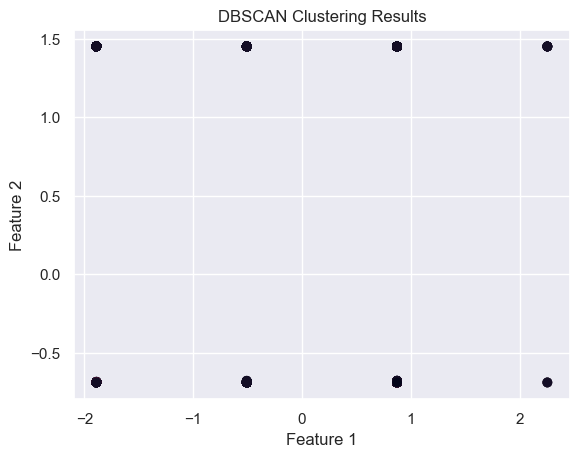

In [602]:
# Choose the best value of eps based on the silhouette score
best_eps = eps[np.argmax(scores)]
print('Best eps: ', best_eps)

# Run DBSCAN with the best value of eps and visualize the results
dbscan = DBSCAN(eps=best_eps, min_samples=k)
dbscan.fit(array_data_numeric_standarized)
plt.scatter(array_data_numeric_standarized[:, 0], array_data_numeric_standarized[:, 1], c=dbscan.labels_)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()

k=4

In [603]:
# Choose a value for k
k = 4

# Compute the distances to the kth nearest neighbor
nearest_neighbors = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(array_data_numeric_standarized)
distances, indices = nearest_neighbors.kneighbors(array_data_numeric_standarized)
k_distances = np.sort(distances[:, -1])

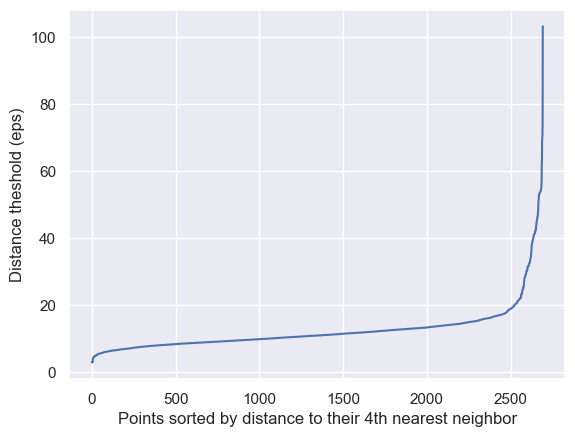

In [604]:
# Plot the sorted distances
plt.plot(k_distances)
plt.xlabel(f'Points sorted by distance to their {k}th nearest neighbor')
plt.ylabel('Distance theshold (eps)')
plt.show()

Best eps:  20.0


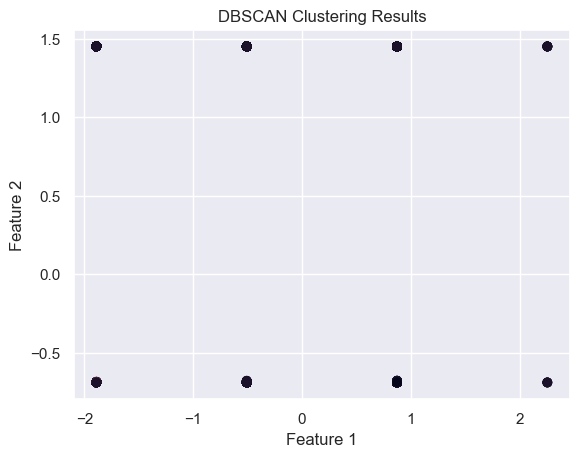

In [606]:
# Choose the best value of eps based on the silhouette score
best_eps = eps[np.argmax(scores)]
print('Best eps: ', best_eps)

# Run DBSCAN with the best value of eps and visualize the results
dbscan = DBSCAN(eps=best_eps, min_samples=k)
dbscan.fit(array_data_numeric_standarized)
plt.scatter(array_data_numeric_standarized[:, 0], array_data_numeric_standarized[:, 1], c=dbscan.labels_)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()

set range of hyperparameters values to try


Best hyperparameters: eps=50.0, min_samples=3


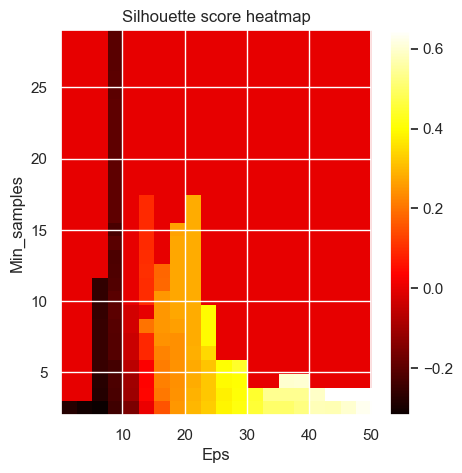

In [607]:
# set range of hyperparameter values to try
eps_range = np.linspace(0.1, 50.0, num=20)
min_samples_range = np.arange(2, 30)

# initialize array to store silhouette scores
silhouette_scores = np.zeros((len(eps_range), len(min_samples_range)))

# loop over hyperparameter values and calculate silhouette scores
for indx_eps, eps in enumerate(eps_range):
    for indx_min_samples, min_samples in enumerate(min_samples_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_numeric_standarized)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            silhouette_scores[indx_eps, indx_min_samples] = \
            silhouette_score(data_numeric_standarized, labels, metric = 'euclidean')


# plot silhouette score heatmap
plt.figure(figsize=(5, 5))
plt.title("Silhouette score heatmap")
plt.xlabel("Eps")
plt.ylabel("Min_samples")
plt.imshow(silhouette_scores.T, cmap='hot', interpolation='nearest',
           extent=[eps_range[0], eps_range[-1], 
                   min_samples_range[0], min_samples_range[-1]],
           aspect='auto', origin='lower')
plt.colorbar()

# select best hyperparameters based on evaluation metrics
best_eps_idx, best_min_samples_idx = np.unravel_index(
    np.argmax(silhouette_scores), silhouette_scores.shape)
best_eps = eps_range[best_eps_idx]
best_min_samples = min_samples_range[best_min_samples_idx]
print(f"Best hyperparameters: eps={best_eps}, min_samples={best_min_samples}")

set a bigger range of hyperparameters values to try

Best hyperparameters: eps=47.42105263157895, min_samples=3


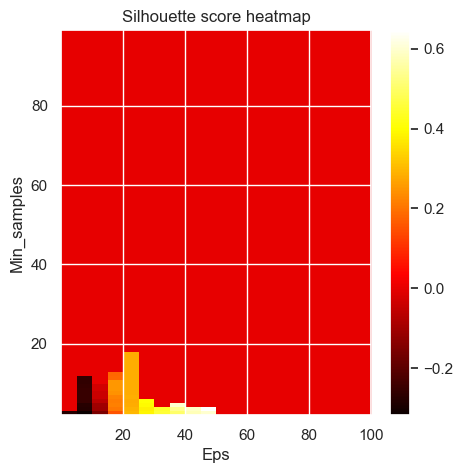

In [608]:
# set range of hyperparameter values to try
eps_range = np.linspace(0.1, 100.0, num=20)
min_samples_range = np.arange(2, 100)

# initialize array to store silhouette scores
silhouette_scores = np.zeros((len(eps_range), len(min_samples_range)))

# loop over hyperparameter values and calculate silhouette scores
for indx_eps, eps in enumerate(eps_range):
    for indx_min_samples, min_samples in enumerate(min_samples_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_numeric_standarized)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            silhouette_scores[indx_eps, indx_min_samples] = \
            silhouette_score(data_numeric_standarized, labels, metric = 'euclidean')


# plot silhouette score heatmap
plt.figure(figsize=(5, 5))
plt.title("Silhouette score heatmap")
plt.xlabel("Eps")
plt.ylabel("Min_samples")
plt.imshow(silhouette_scores.T, cmap='hot', interpolation='nearest',
           extent=[eps_range[0], eps_range[-1], 
                   min_samples_range[0], min_samples_range[-1]],
           aspect='auto', origin='lower')
plt.colorbar()

# select best hyperparameters based on evaluation metrics
best_eps_idx, best_min_samples_idx = np.unravel_index(
    np.argmax(silhouette_scores), silhouette_scores.shape)
best_eps = eps_range[best_eps_idx]
best_min_samples = min_samples_range[best_min_samples_idx]
print(f"Best hyperparameters: eps={best_eps}, min_samples={best_min_samples}")

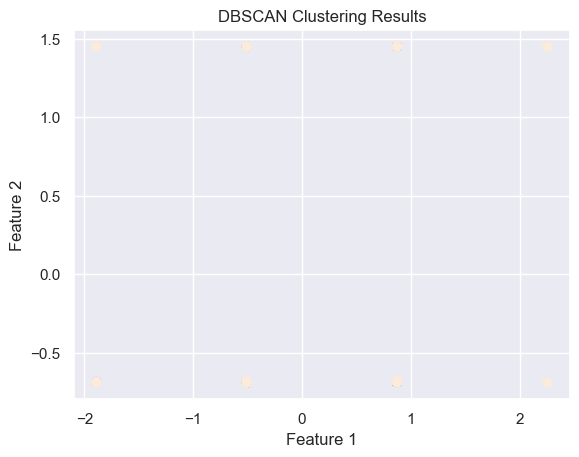

In [629]:
# Run DBSCAN with the best value of eps and visualize the results
dbscan = DBSCAN(eps=best_eps, min_samples=k)
dbscan.fit(array_data_numeric_standarized)
plt.scatter(array_data_numeric_standarized[:, 0], array_data_numeric_standarized[:, 1], c=dbscan.labels_)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering Results')
plt.show()

Create DBSCAN object with resulted best hyperparameters and observe its silhouette score


In [630]:
# Create DBSCAN object with resulted best hyperparameters
dbscan = DBSCAN(eps=47.42105263157895, metric='euclidean', 
                min_samples=3)

# Fit model and predict clusters
labels = dbscan.fit_predict(data_numeric_standarized)

# retrieve unique clusters
unique_labels = set(labels)
# get number of unique clusters
no_clusters = len(unique_labels)
# get number of noise
no_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'unique_labels = {unique_labels}')
print(f'Number of clusters in DBSCAN = {no_clusters}')
print(f'Number of noise in DBSCAN = {no_noise}')

# Compute silhouette score
silhouette_avg = silhouette_score(data_numeric_standarized, labels)

# Print silhouette score
print("The average silhouette score for DBSCAN with eps=50 and min_samples=1 is:", silhouette_avg)

unique_labels = {0, 1, -1}
Number of clusters in DBSCAN = 3
Number of noise in DBSCAN = 26
The average silhouette score for DBSCAN with eps=50 and min_samples=1 is: 0.6462276347724093


This silhouette score is higher than the previous one. Prior iteration's results were: 
* unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
* Number of clusters in DBSCAN = 25
* Number of noise in DBSCAN = 0
* The average silhouette score for DBSCAN with eps=50 and min_samples=1 is: 0.6216429064152031 

In [631]:
# Extract the cluster centers
unique_labels = set(labels)
cluster_centers = []
for label in unique_labels:
    if label != -1:
        cluster_centers.append(data_numeric_standarized[labels == label].mean(axis=0))

# Print the number of clusters and their centers
n_clusters = len(cluster_centers)
print(f"Number of clusters found: {n_clusters}\n")
print("Cluster centers:")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1}:")
    print(f"{center}\n\n")

Number of clusters found: 2

Cluster centers:
Cluster 1:
smartphone_type               -0.003291
jobs_count                     0.003493
bike_num_days                 -0.000051
survey_mode_Call center        0.001163
survey_mode_rMove             -0.000127
                                 ...   
cms_zone_Northern Manhattan   -0.002064
cms_zone_Outer Brooklyn        0.003636
cms_zone_Outer Queens         -0.000805
cms_zone_Southern Bronx        0.000163
cms_zone_Staten Island        -0.004159
Length: 295, dtype: float64


Cluster 2:
smartphone_type                0.413289
jobs_count                    -0.690243
bike_num_days                 -1.178846
survey_mode_Call center       -0.252213
survey_mode_rMove              0.679305
                                 ...   
cms_zone_Northern Manhattan   -0.304920
cms_zone_Outer Brooklyn       -0.333883
cms_zone_Outer Queens         -0.359437
cms_zone_Southern Bronx        0.725385
cms_zone_Staten Island        -0.365993
Length: 295, dtype: fl

# PCA

In [619]:
pca_model2 = PCA(n_components = 2)
pca_model2.fit(data_numeric_standarized)

PCA(n_components=2)

In [620]:
training_data_pca2 = pca_model2.transform(data_numeric_standarized)
centers_pca2 = pca_model2.transform(cluster_centers)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [621]:
(training_data_pca2).shape

(2692, 2)

In [622]:
centers_pca2

array([[-3.56238525e-02,  1.23415162e-02],
       [ 1.23575498e+01, -5.66671712e+00]])

In [623]:
pca_dataframe = pd.DataFrame(data=training_data_pca2,
                             columns=['pca1','pca2'])
pca_dataframe

,pca1,pca2
0,6.596236,1.914446
1,-2.768408,-3.342375
2,-2.759231,-1.359455
3,12.153256,-6.432527
4,-2.548258,-1.348108
...,...,...
2687,-2.507472,0.380378
2688,-2.727481,-2.845917
2689,-2.242127,-0.579301
2690,-2.416039,-2.176546


In [624]:
pca_df = pd.concat([pca_dataframe, pd.DataFrame({'cluster': labels})], axis=1)
pca_df

,pca1,pca2,cluster
0,6.596236,1.914446,0
1,-2.768408,-3.342375,0
2,-2.759231,-1.359455,0
3,12.153256,-6.432527,1
4,-2.548258,-1.348108,0
...,...,...,...
2687,-2.507472,0.380378,0
2688,-2.727481,-2.845917,0
2689,-2.242127,-0.579301,0
2690,-2.416039,-2.176546,0


In [625]:
unique_vals, counts = np.unique(labels, return_counts=True)

In [626]:
for val, count in zip(unique_vals, counts):
    print(f"{val}: {count}")

-1: 26
0: 2663
1: 3


* We have 24 sample of noise data

* Almost all the data included in cluster0

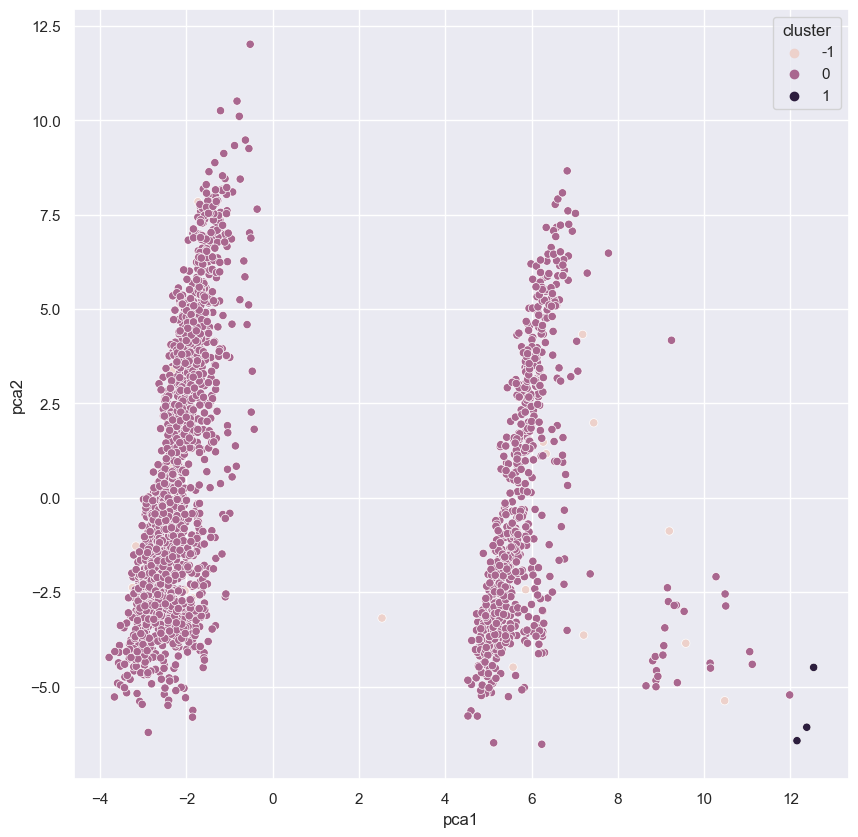

In [632]:
plt.figure(figsize=(10,10))
ax= sns.scatterplot(x="pca1", y="pca2", hue="cluster",data=pca_df, )
plt.show()

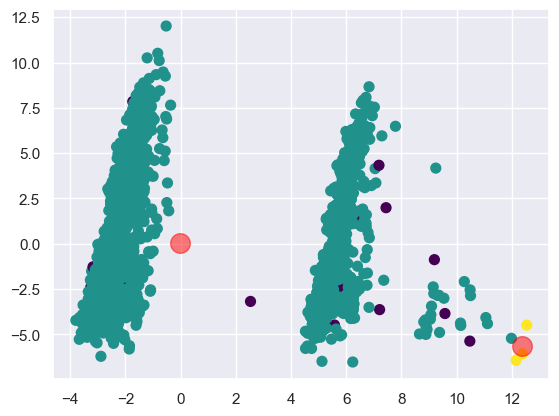

In [633]:
plt.scatter(training_data_pca2[:, 0],
            training_data_pca2[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers_pca2[:, 0], centers_pca2[:, 1], c='red', s=200, alpha=0.5)

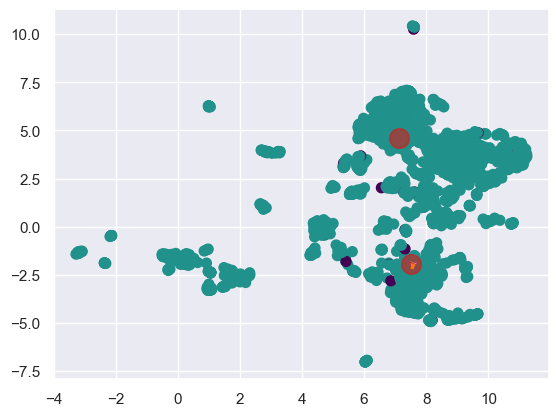

In [634]:
import umap.umap_ as umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric_standarized)
training_data_embedding = umap_model.transform(data_numeric_standarized)
centers_embedding = umap_model.transform(cluster_centers)

# plot the data in the low dim with the cluster results
plt.scatter(training_data_embedding[:, 0],
            training_data_embedding[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers_embedding[:, 0], centers_embedding[:, 1], c='red', s=200, alpha=0.5)
plt.show(block=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.92, '3D PCA plot')

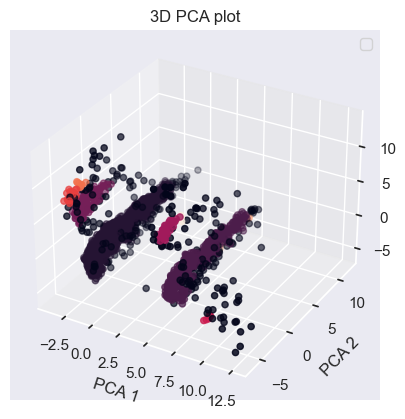

In [636]:
# pca 3D > then DBSCAN > then visualizatin
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# apply PCA to reduce the dimensions to 3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(data_numeric_standarized)

# apply DBSCAN clustering algorithm on the reduced data
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_pca)

# plot the clusters in a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=dbscan.labels_)
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
# plt.show()
ax.legend()
plt.title("3D PCA plot")


[smartphone_type               -0.003291
jobs_count                     0.003493
bike_num_days                 -0.000051
survey_mode_Call center        0.001163
survey_mode_rMove             -0.000127
                                 ...   
cms_zone_Northern Manhattan   -0.002064
cms_zone_Outer Brooklyn        0.003636
cms_zone_Outer Queens         -0.000805
cms_zone_Southern Bronx        0.000163
cms_zone_Staten Island        -0.004159
Length: 295, dtype: float64, smartphone_type                0.413289
jobs_count                    -0.690243
bike_num_days                 -1.178846
survey_mode_Call center       -0.252213
survey_mode_rMove              0.679305
                                 ...   
cms_zone_Northern Manhattan   -0.304920
cms_zone_Outer Brooklyn       -0.333883
cms_zone_Outer Queens         -0.359437
cms_zone_Southern Bronx        0.725385
cms_zone_Staten Island        -0.365993
Length: 295, dtype: float64]
[[-3.56240860e-02  1.23407015e-02  2.11029082e-02]
 [ 1.23577

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Text(0.5, 0.92, '3D PCA plot')

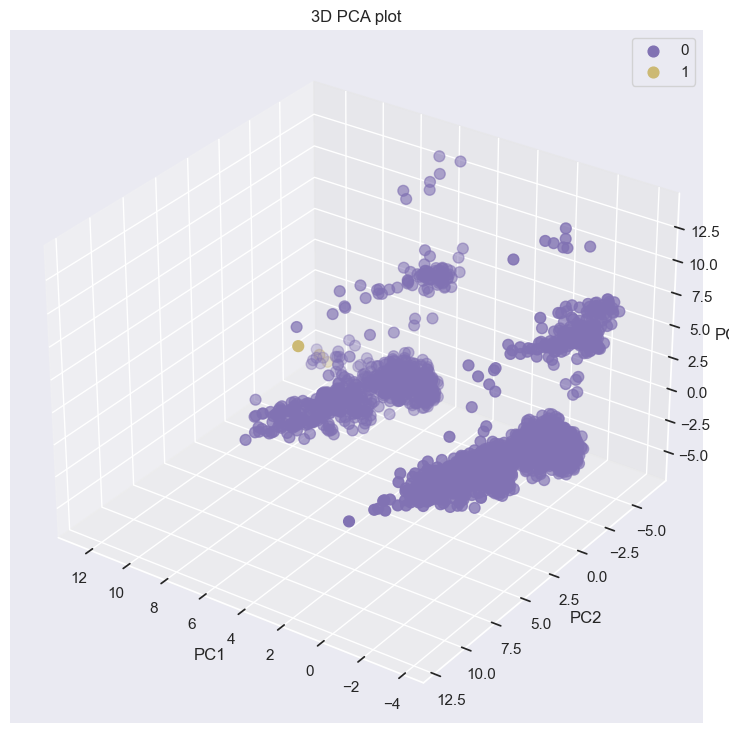

In [637]:
pca_3d_dbscan = PCA(n_components=3)
pca_3d_dbscan.fit(data_numeric_standarized)
pca_bcancer_dbscan = pca_3d_dbscan.transform(data_numeric_standarized)
pca_centers_dbscan = pca_3d_dbscan.transform(cluster_centers)
print(cluster_centers)
print(pca_centers_dbscan)
# map each cluster label to a specific color that will be used to plot the corresponding data points
cdict = {0:'m',1:'y'} # 'm' = magenta, 'c' = cyan
label = {0:'0',1:'1'}
y = labels

Xax = pca_bcancer_dbscan[:,0]
Yax = pca_bcancer_dbscan[:,1]
Zax = pca_bcancer_dbscan[:,2]

fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, 
                     projection='3d')

for l in np.unique(y):
    if l != -1:
        ix = np.where(y == l)
        ax.scatter(Xax[ix], 
                   Yax[ix], 
                   Zax[ix], 
                   c=cdict[l], 
                   s=60,
                   label=label[l]) 


ax.set_xlabel("PC1", 
              fontsize=12)
ax.set_ylabel("PC2", 
              fontsize=12)
ax.set_zlabel("PC3", 
              fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")

In [638]:
# Create DBSCAN object with resulted best hyperparameters
dbscan = DBSCAN(eps=47.42105263157895, metric='euclidean', 
                min_samples=3)

# Fit model and predict clusters
labels = dbscan.fit_predict(data_numeric)

# retrieve unique clusters
unique_labels = set(labels)
# get number of unique clusters
no_clusters = len(unique_labels)
# get number of noise
no_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'unique_labels = {unique_labels}')
print(f'Number of clusters in DBSCAN = {no_clusters}')
print(f'Number of noise in DBSCAN = {no_noise}')

# Compute silhouette score
silhouette_avg = silhouette_score(data_numeric, labels)

# Print silhouette score
print("The average silhouette score for DBSCAN with eps=50 and min_samples=1 is:", silhouette_avg)

unique_labels = {0, 1, 2, 3}
Number of clusters in DBSCAN = 4
Number of noise in DBSCAN = 0
The average silhouette score for DBSCAN with eps=50 and min_samples=1 is: 0.9941364992523383


This silhouette score is higher than the previous one. Prior iteration's results were: 
* unique_labels = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
* Number of clusters in DBSCAN = 25
* Number of noise in DBSCAN = 0
* The average silhouette score for DBSCAN with eps=50 and min_samples=1 is: 0.6216429064152031 

In [639]:
# Extract the cluster centers
unique_labels = set(labels)
cluster_centers = []
for label in unique_labels:
    if label != -1:
        cluster_centers.append(data_numeric[labels == label].mean(axis=0))

# Print the number of clusters and their centers
n_clusters = len(cluster_centers)
print(f"Number of clusters found: {n_clusters}\n")
print("Cluster centers:")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1}:")
    print(f"{center}\n\n")

Number of clusters found: 4

Cluster centers:
Cluster 1:
smartphone_type                  1.341538
jobs_count                     995.000000
bike_num_days                    0.335385
survey_mode_Call center          0.046154
survey_mode_rMove                0.784615
                                  ...    
cms_zone_Northern Manhattan      0.052308
cms_zone_Outer Brooklyn          0.073846
cms_zone_Outer Queens            0.153846
cms_zone_Southern Bronx          0.132308
cms_zone_Staten Island           0.129231
Length: 295, dtype: float64


Cluster 2:
smartphone_type                1.571788
jobs_count                     1.211587
bike_num_days                  0.343829
survey_mode_Call center        0.008816
survey_mode_rMove              0.794710
                                 ...   
cms_zone_Northern Manhattan    0.090680
cms_zone_Outer Brooklyn        0.105793
cms_zone_Outer Queens          0.117128
cms_zone_Southern Bronx        0.089421
cms_zone_Staten Island         0.117128


In [640]:
pca_model2 = PCA(n_components = 2)
pca_model2.fit(data_numeric)

PCA(n_components=2)

In [641]:
training_data_pca2 = pca_model2.transform(data_numeric)
centers_pca2 = pca_model2.transform(cluster_centers)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [642]:
(training_data_pca2).shape

(2692, 2)

In [643]:
centers_pca2

array([[ 264.64175762,  849.23465455],
       [ 660.7521229 ,  -62.20306423],
       [-251.45857184, -458.70432776],
       [-647.59378971,  452.76874377]])

In [644]:
pca_dataframe = pd.DataFrame(data=training_data_pca2,
                             columns=['pca1','pca2'])
pca_dataframe

,pca1,pca2
0,263.116649,848.572194
1,661.151315,-62.261243
2,661.150464,-62.260849
3,656.568010,-64.252272
4,-251.789975,-457.942630
...,...,...
2687,-251.393194,-458.857566
2688,-251.391922,-458.858694
2689,-251.391316,-458.859929
2690,-251.391673,-458.861342


In [645]:
pca_df = pd.concat([pca_dataframe, pd.DataFrame({'cluster': labels})], axis=1)
pca_df

,pca1,pca2,cluster
0,263.116649,848.572194,0
1,661.151315,-62.261243,1
2,661.150464,-62.260849,1
3,656.568010,-64.252272,1
4,-251.789975,-457.942630,2
...,...,...,...
2687,-251.393194,-458.857566,2
2688,-251.391922,-458.858694,2
2689,-251.391316,-458.859929,2
2690,-251.391673,-458.861342,2


In [646]:
unique_vals, counts = np.unique(labels, return_counts=True)
for val, count in zip(unique_vals, counts):
    print(f"{val}: {count}")

0: 325
1: 794
2: 1030
3: 543


* We have 24 sample of noise data
* Almost all the data included in cluster0

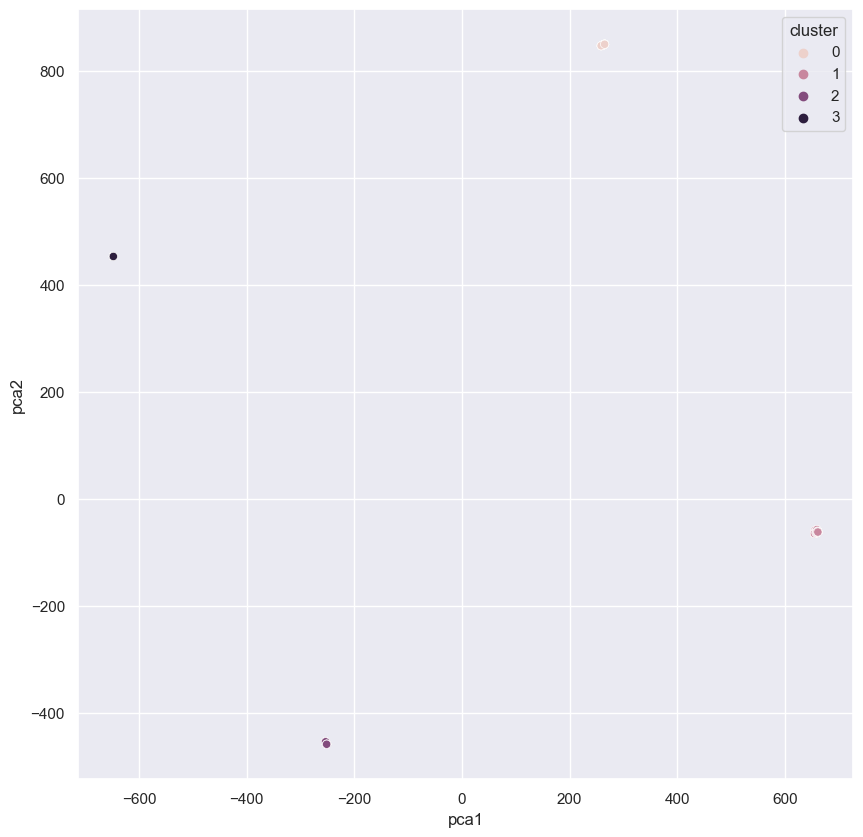

In [647]:
plt.figure(figsize=(10,10))
ax= sns.scatterplot(x="pca1", y="pca2", hue="cluster",data=pca_df, )
plt.show()

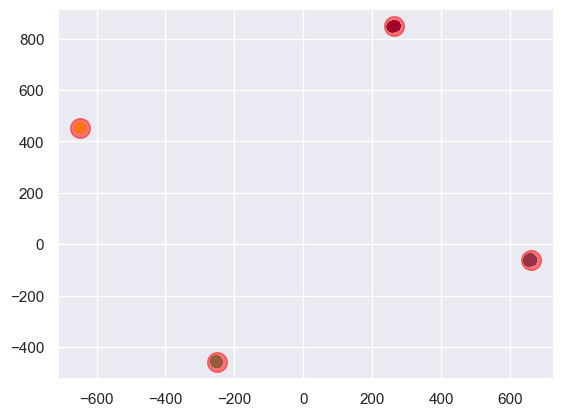

In [648]:
plt.scatter(training_data_pca2[:, 0],
            training_data_pca2[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers_pca2[:, 0], centers_pca2[:, 1], c='red', s=200, alpha=0.5)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


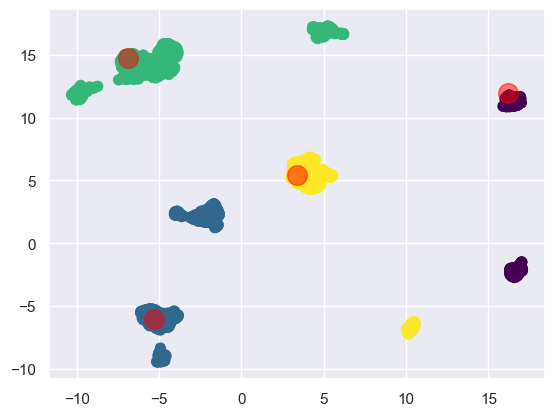

In [649]:
import umap.umap_ as umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric)
training_data_embedding = umap_model.transform(data_numeric)
centers_embedding = umap_model.transform(cluster_centers)

# plot the data in the low dim with the cluster results
plt.scatter(training_data_embedding[:, 0],
            training_data_embedding[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers_embedding[:, 0], centers_embedding[:, 1], c='red', s=200, alpha=0.5)
plt.show(block=True)

* Try DBSCAN without scaling data 
* As DBSCAN is very sensitive to scale since epsilon is a fixed value for the maximum distance between two point

Best hyperparameters: eps=10.615789473684211, min_samples=2


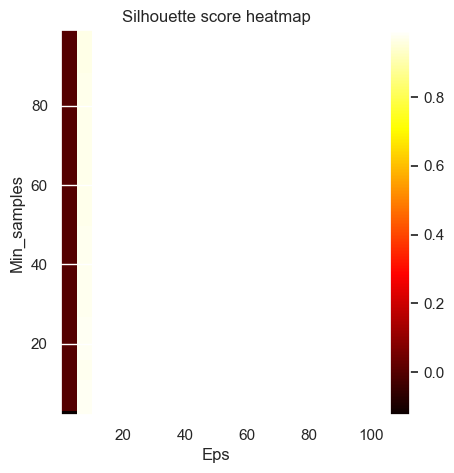

In [650]:
# set range of hyperparameter values to try
eps_range = np.linspace(0.1, 100.0, num=20)
min_samples_range = np.arange(2, 100)

# initialize array to store silhouette scores
silhouette_scores = np.zeros((len(eps_range), len(min_samples_range)))

# loop over hyperparameter values and calculate silhouette scores
for indx_eps, eps in enumerate(eps_range):
    for indx_min_samples, min_samples in enumerate(min_samples_range):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data_numeric)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            silhouette_scores[indx_eps, indx_min_samples] = \
            silhouette_score(data_numeric, labels, metric = 'euclidean')


# plot silhouette score heatmap
plt.figure(figsize=(5, 5))
plt.title("Silhouette score heatmap")
plt.xlabel("Eps")
plt.ylabel("Min_samples")
plt.imshow(silhouette_scores.T, cmap='hot', interpolation='nearest',
           extent=[eps_range[0], eps_range[-1], 
                   min_samples_range[0], min_samples_range[-1]],
           aspect='auto', origin='lower')
plt.colorbar()

# select best hyperparameters based on evaluation metrics
best_eps_idx, best_min_samples_idx = np.unravel_index(
    np.argmax(silhouette_scores), silhouette_scores.shape)
best_eps = eps_range[best_eps_idx]
best_min_samples = min_samples_range[best_min_samples_idx]
print(f"Best hyperparameters: eps={best_eps}, min_samples={best_min_samples}")

Create DBSCAN Object from Best hyperparameters:  
* eps=10.615789473684211
* min_samples=2

In [651]:
# Create DBSCAN object
eps=10.615789473684211
min_samples=2

dbscan = DBSCAN(eps=eps, metric='euclidean', 
                min_samples=min_samples)

# Fit model and predict clusters
labels = dbscan.fit_predict(data_numeric)

# retrieve unique clusters
unique_labels = set(labels)
# get number of unique clusters
no_clusters = len(unique_labels)
# get number of noise
no_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'unique_labels = {unique_labels}')
print(f'Number of clusters in DBSCAN = {no_clusters}')
print(f'Number of noise in DBSCAN = {no_noise}')

# Compute silhouette score
silhouette_avg = silhouette_score(data_numeric, labels)

# Print silhouette score
print(f'The average silhouette score for DBSCAN with eps={eps} and min_samples={min_samples} is:', silhouette_avg)

unique_labels = {0, 1, 2, 3}
Number of clusters in DBSCAN = 4
Number of noise in DBSCAN = 0
The average silhouette score for DBSCAN with eps=10.615789473684211 and min_samples=2 is: 0.9941364992523383


This silhouette score for unscaled data is higher than the previous ones with scaled data. Prior iteration's results were: 
* unique_labels = {0, 1, -1}
* Number of clusters in DBSCAN = 3
* Number of noise in DBSCAN = 24
* The average silhouette score for DBSCAN with eps=50 and min_samples=1 is: 0.6540386685617618

In [652]:
# Extract the cluster centers
unique_labels = set(labels)
cluster_centers = []
for label in unique_labels:
    if label != -1:
        cluster_centers.append(data_numeric[labels == label].mean(axis=0))

# Print the number of clusters and their centers
n_clusters = len(cluster_centers)
print(f"Number of clusters found: {n_clusters}\n")
print("Cluster centers:")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1}:")
    print(f"{center}\n\n")

Number of clusters found: 4

Cluster centers:
Cluster 1:
smartphone_type                  1.341538
jobs_count                     995.000000
bike_num_days                    0.335385
survey_mode_Call center          0.046154
survey_mode_rMove                0.784615
                                  ...    
cms_zone_Northern Manhattan      0.052308
cms_zone_Outer Brooklyn          0.073846
cms_zone_Outer Queens            0.153846
cms_zone_Southern Bronx          0.132308
cms_zone_Staten Island           0.129231
Length: 295, dtype: float64


Cluster 2:
smartphone_type                1.571788
jobs_count                     1.211587
bike_num_days                  0.343829
survey_mode_Call center        0.008816
survey_mode_rMove              0.794710
                                 ...   
cms_zone_Northern Manhattan    0.090680
cms_zone_Outer Brooklyn        0.105793
cms_zone_Outer Queens          0.117128
cms_zone_Southern Bronx        0.089421
cms_zone_Staten Island         0.117128


# PCA

In [653]:
pca_model2 = PCA(n_components = 2)
pca_model2.fit(data_numeric)

PCA(n_components=2)

In [654]:
training_data_pca2 = pca_model2.transform(data_numeric)
centers_pca2 = pca_model2.transform(cluster_centers)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [655]:
(training_data_pca2).shape

(2692, 2)

In [656]:
centers_pca2

array([[ 264.64175762,  849.23465455],
       [ 660.7521229 ,  -62.20306423],
       [-251.45857184, -458.70432776],
       [-647.59378971,  452.76874377]])

In [657]:
pca_dataframe = pd.DataFrame(data=training_data_pca2,
                             columns=['pca1','pca2'])
pca_dataframe

,pca1,pca2
0,263.116649,848.572194
1,661.151315,-62.261243
2,661.150464,-62.260849
3,656.568010,-64.252272
4,-251.789975,-457.942630
...,...,...
2687,-251.393194,-458.857566
2688,-251.391922,-458.858694
2689,-251.391316,-458.859929
2690,-251.391673,-458.861342


In [658]:
pca_df = pd.concat([pca_dataframe, pd.DataFrame({'cluster': labels})], axis=1)
pca_df

,pca1,pca2,cluster
0,263.116649,848.572194,0
1,661.151315,-62.261243,1
2,661.150464,-62.260849,1
3,656.568010,-64.252272,1
4,-251.789975,-457.942630,2
...,...,...,...
2687,-251.393194,-458.857566,2
2688,-251.391922,-458.858694,2
2689,-251.391316,-458.859929,2
2690,-251.391673,-458.861342,2


In [659]:
unique_vals, counts = np.unique(labels, return_counts=True)

In [660]:
for val, count in zip(unique_vals, counts):
    print(f"{val}: {count}")

0: 325
1: 794
2: 1030
3: 543


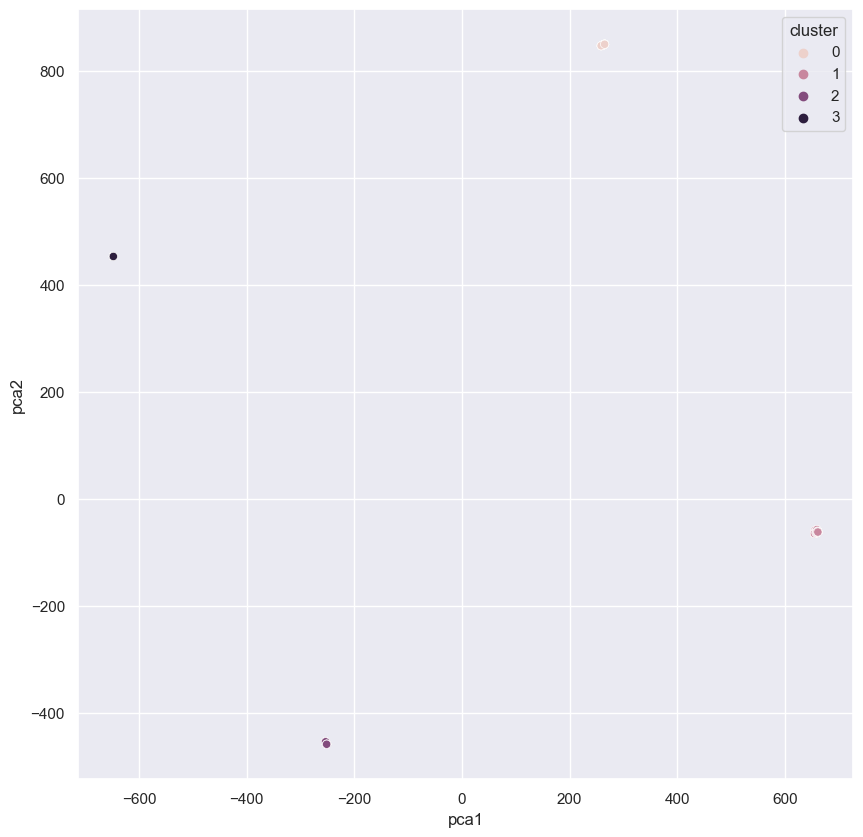

In [661]:
plt.figure(figsize=(10,10))
ax= sns.scatterplot(x="pca1", y="pca2", hue="cluster",data=pca_df, )
plt.show()

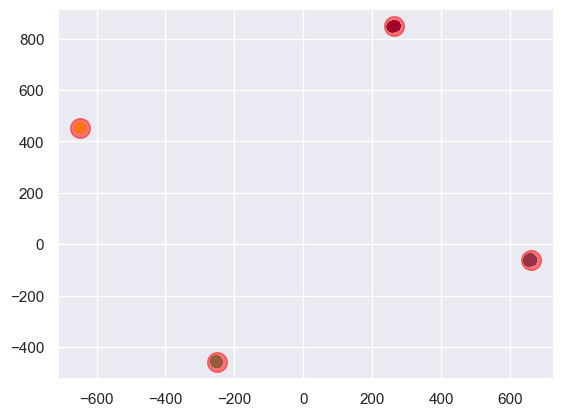

In [662]:
plt.scatter(training_data_pca2[:, 0],
            training_data_pca2[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers_pca2[:, 0], centers_pca2[:, 1], c='red', s=200, alpha=0.5)

c:\Users\nasser\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


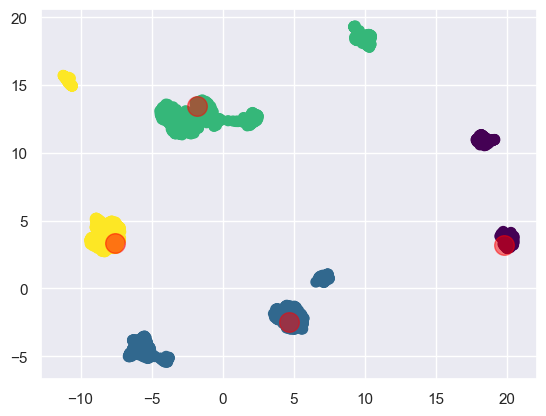

In [663]:
import umap.umap_ as umap
reducer = umap.UMAP(n_components=2)
umap_model = reducer.fit(data_numeric)
training_data_embedding = umap_model.transform(data_numeric)
centers_embedding = umap_model.transform(cluster_centers)

# plot the data in the low dim with the cluster results
plt.scatter(training_data_embedding[:, 0],
            training_data_embedding[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers_embedding[:, 0], centers_embedding[:, 1], c='red', s=200, alpha=0.5)
plt.show(block=True)

# Hyper Parameter Tuning
finding the optimal k by visiualizing dendrogram


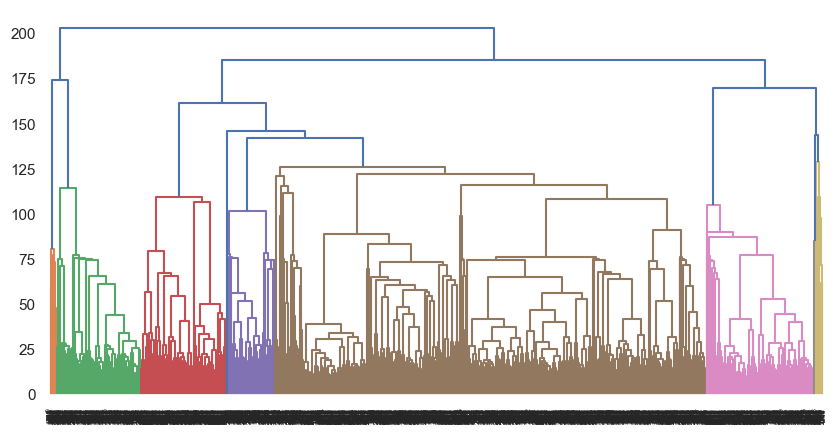

In [666]:
# Compute distances matrix
Z = linkage(data_numeric_standarized, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.show()

In [667]:
# Extract clusters based on distance threshold
distance_threshold = 160 # Maximum distance between points in a cluster.
clusters = fcluster(Z, t=distance_threshold, criterion='distance')

In [668]:
unique_clusters = np.unique(clusters)
unique_clusters

array([1, 2, 3, 4, 5, 6], dtype=int32)

finding the optimal k using silhouette_score


In [669]:
def silhouette_method(data, K):
    """
    Finds the optimal number of clusters using the silhouette score method for agglomerative clustering.
    
    Args:
        data (numpy array): The data matrix.
        K (tuple): The range of values for k to evaluate.
        
    Returns:
        optimal_k (int): The optimal number of clusters.
        silhouette_scores (list): The silhouette scores for each value of k.
    """
    silhouette_scores = []
    k_values = range(K[0], K[1])
    
    for k in k_values:
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)

    plt.plot(k_values, silhouette_scores, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()
    
    optimal_k = k_values[np.argmax(silhouette_scores)]
    return optimal_k, silhouette_scores

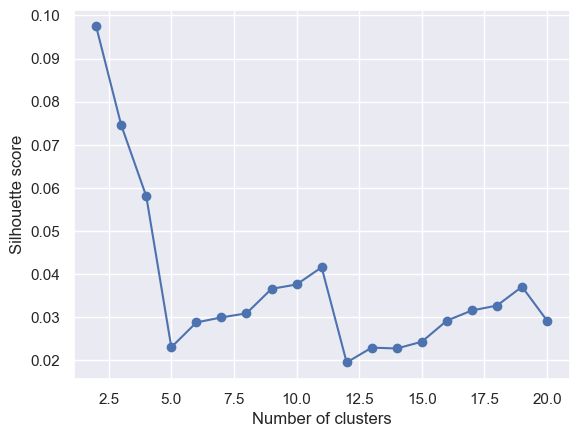

In [670]:
optimal_sil_k, sil_scores = silhouette_method(data_numeric_standarized, K=(2, 21))

In [671]:
print("optimal K using silhouette_score" ,optimal_sil_k)

optimal K using silhouette_score 2


In [672]:
data_numeric_standarized.shape

(2692, 295)

In [673]:
clusters

array([1, 4, 4, ..., 4, 4, 5], dtype=int32)

# Modeling

In [674]:
agglomerative_model = AgglomerativeClustering(distance_threshold=None,
                                n_clusters=2,
                                linkage='ward',
                                affinity='euclidean')
predicted_clusters_hierarchicaly = agglomerative_model.fit_predict(data_numeric_standarized)

In [675]:
np.unique(predicted_clusters_hierarchicaly)

array([0, 1], dtype=int64)

In [676]:
agg_labels = agglomerative_model.labels_
agg_labels

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

# Evaluating

use PCA to reduce the dimentions of the data to plot it in 2d space


In [677]:
# Reduce dimensionality of the data using PCA
pca = PCA(n_components=2)
X_agg_pca = pca.fit_transform(data_numeric_standarized)

# Cluster the reduced data using Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=2)
agg.fit(X_agg_pca)

# Get the cluster labels
labels = agg.labels_

# Print the results
print("Cluster labels: ", labels)

Cluster labels:  [1 0 0 ... 0 0 1]


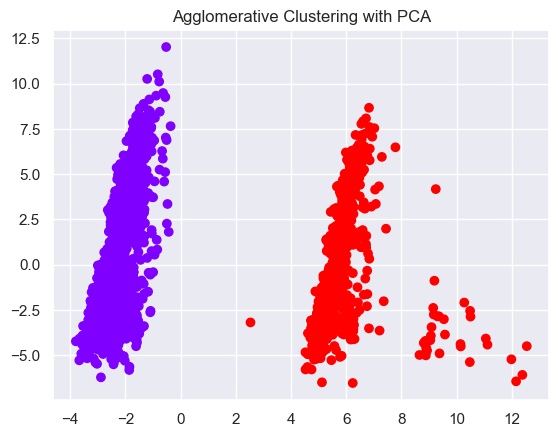

In [678]:
# Plot the clustered data "agglomerative"
plt.scatter(X_agg_pca[:, 0], X_agg_pca[:, 1], c=labels, cmap='rainbow')
plt.title('Agglomerative Clustering with PCA')
plt.show()

In [679]:
# Compute the Calinski-Harabasz 
# This method measures the ratio of the between-cluster variance to the within-cluster variance
ch_score = calinski_harabasz_score(data_numeric_standarized, predicted_clusters_hierarchicaly)

print('Calinski-Harabasz Index:', ch_score)

Calinski-Harabasz Index: 73.72105406708049


In [680]:
# Agglomerative model with 12 clusters
n_clusters = 12
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = model.fit_predict(data_numeric_standarized)
# Compute the Calinski-Harabasz 
# This method measures the ratio of the between-cluster variance to the within-cluster variance
ch_score = calinski_harabasz_score(data_numeric_standarized, labels)

print('Calinski-Harabasz Index:', ch_score)

Calinski-Harabasz Index: 51.75155051464896


In [681]:
# Agglomerative model with 6 clusters
n_clusters = 6
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = model.fit_predict(data_numeric_standarized)
# Compute the Calinski-Harabasz 
# This method measures the ratio of the between-cluster variance to the within-cluster variance
ch_score = calinski_harabasz_score(data_numeric_standarized, labels)

print('Calinski-Harabasz Index:', ch_score)

Calinski-Harabasz Index: 62.4201773008476


In [682]:
data_numeric_standarized['predicted_clusters_hierarchicaly'] = predicted_clusters_hierarchicaly

In [683]:
data_numeric_standarized['predicted_clusters_hierarchicaly']

0       1
1       0
2       0
3       0
4       0
       ..
2687    0
2688    1
2689    0
2690    0
2691    0
Name: predicted_clusters_hierarchicaly, Length: 2692, dtype: int64